# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Loading the dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 321467484.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45797993.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 135576471.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6310211.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# CNN Architecture

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(SimpleCNN, self).__init__()

        layers = []
        layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block = nn.Sequential(*layers)

        fc_layers = []
        fc_layers.append(nn.Linear(32*7*7, 500))
        if use_batch_norm:
            fc_layers.append(nn.BatchNorm1d(500))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Linear(500, 10))
        self.fc_block = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

# Functions for Training, Testing, Plotting, and Other Analyses

## Helper function to return type of optimizer to be used

In [7]:
def get_optimizer(optimizer_type, parameters, lr=0.001, momentum=0.9, weight_decay=0):
    if optimizer_type == "SGD":
        return optim.SGD(parameters, lr=lr)
    elif optimizer_type == "Momentum":
        return optim.SGD(parameters, lr=lr, momentum=momentum)
    elif optimizer_type == "RMSProp":
        return optim.RMSprop(parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_type == "Adam":
        return optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer type {optimizer_type} not recognized.")

## Training, plotting, returning the best model

**Note**: We use 5 epochs for training because with higher number of epochs( say, 10) all optimizers other than SGD achieve high test accuracies. If all have high accuracies, an objective comparison becomes difficult. When training for 10 epochs, Momentum almost always gives a test accuracy of close to 98% and RMSProp and Adam both achieve 99%+ test accuracy, meaning commenting upon the performance becomes difficult as the slight variations might have been due to intialization of layers, randomness, floating point numbers, etc.

In [8]:
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
def train_and_evaluate(optimizer_type, use_batch_norm=False, update_best_model=True):
    net = SimpleCNN(use_batch_norm=use_batch_norm).to(device)
    optimizer = get_optimizer(optimizer_type, net.parameters())

    num_epochs = 5
    train_losses, val_losses, accuracies = [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = 100. * correct / total

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        accuracies.append(epoch_val_accuracy)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Training using {optimizer_type} with BatchNorm={use_batch_norm} took {elapsed_time:.2f} seconds.")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(f'{optimizer_type} - Train and Validation Losses')

    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{optimizer_type} - Validation Accuracy')

    plt.tight_layout()
    plt.show()

    test_preds, test_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            test_true.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

    acc = 100. * sum(np.array(test_true) == np.array(test_preds)) / len(test_true)

    global best_accuracy, best_optimizer, best_model
    if update_best_model and acc > best_accuracy:
        best_accuracy = acc
        best_optimizer = optimizer_type
        best_model = net

    return acc, classification_report(test_true, test_preds), confusion_matrix(test_true, test_preds), net


## Plotting random images from the test set

In [10]:
def plot_predictions(model, loader, num_samples=12):
    all_images, all_labels = [], []
    for images, labels in loader:
        all_images.append(images)
        all_labels.append(labels)
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    random_indices = random.sample(range(len(all_images)), num_samples)
    images = all_images[random_indices]
    labels = all_labels[random_indices]

    outputs = model(images.to(device))
    _, predictions = outputs.max(1)

    grid_size = int(math.ceil(math.sqrt(num_samples)))

    plt.figure(figsize=(15, 15))
    for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(img[0].numpy(), cmap='gray')
        plt.title(f"True: {label.item()}, Pred: {pred.item()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Function to count the number of parameters and neurons

In [11]:
def count_parameters_and_neurons(model):
    total_params = 0
    fc_params = 0
    conv_params = 0

    total_neurons = 0
    fc_neurons = 0
    conv_neurons = 0

    h, w = 28, 28

    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            conv_params += sum(p.numel() for p in layer.parameters())

            # spatial dimensions after convolution
            h = (h + 2*layer.padding[0] - layer.kernel_size[0]) // layer.stride[0] + 1
            w = (w + 2*layer.padding[1] - layer.kernel_size[1]) // layer.stride[1] + 1

            conv_neurons += layer.out_channels * h * w

        # For MaxPool2d layer
        elif isinstance(layer, nn.MaxPool2d):
            h = (h - layer.kernel_size) // layer.stride + 1
            w = (w - layer.kernel_size) // layer.stride + 1

        # For Linear (fully connected) layer
        elif isinstance(layer, nn.Linear):
            fc_params += sum(p.numel() for p in layer.parameters())
            fc_neurons += layer.out_features

        # For nested modules
        elif isinstance(layer, nn.Sequential):
            sub_results = count_parameters_and_neurons(layer)
            conv_params += sub_results['conv_parameters']
            fc_params += sub_results['fc_parameters']
            conv_neurons += sub_results['conv_neurons']
            fc_neurons += sub_results['fc_neurons']

    total_params = conv_params + fc_params
    total_neurons = conv_neurons + fc_neurons

    print(f"Total parameters: {total_params}")
    print(f"Parameters in FC layers: {fc_params}")
    print(f"Parameters in Conv layers: {conv_params}")

    print(f"Total neurons: {total_neurons}")
    print(f"Neurons in FC layers: {fc_neurons}")
    print(f"Neurons in Conv layers: {conv_neurons}")

    return {
        "total_parameters": total_params,
        "fc_parameters": fc_params,
        "conv_parameters": conv_params,
        "total_neurons": total_neurons,
        "fc_neurons": fc_neurons,
        "conv_neurons": conv_neurons
    }

# Comparing and plotting the performance of 4 optimizers and saving the best model

In [12]:
optimizer_types = ["SGD", "Momentum", "RMSProp", "Adam"]
results = {}
best_accuracy = 0
best_optimizer = None
best_model = None

## Save the information of performance with the 4 optimizers

Epoch: 1/5, Train Loss: 2.2845, Validation Loss: 2.2662, Validation Accuracy: 46.46%
Epoch: 2/5, Train Loss: 2.2384, Validation Loss: 2.1989, Validation Accuracy: 61.65%
Epoch: 3/5, Train Loss: 2.1155, Validation Loss: 1.9848, Validation Accuracy: 64.41%
Epoch: 4/5, Train Loss: 1.6937, Validation Loss: 1.3206, Validation Accuracy: 72.64%
Epoch: 5/5, Train Loss: 0.9939, Validation Loss: 0.7637, Validation Accuracy: 79.80%
Training using SGD with BatchNorm=False took 45.65 seconds.


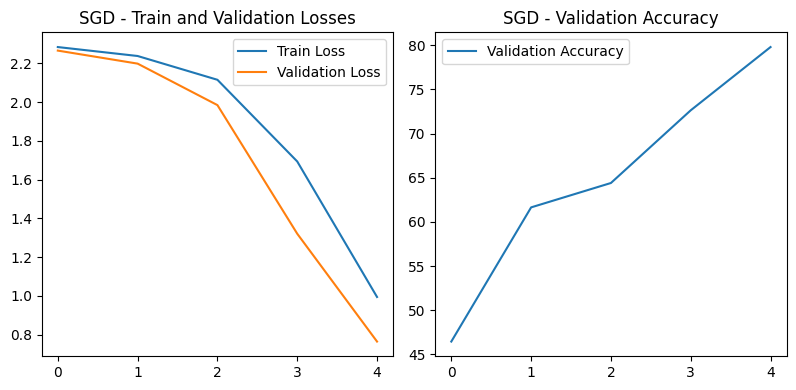

Epoch: 1/5, Train Loss: 1.6343, Validation Loss: 0.4655, Validation Accuracy: 86.01%
Epoch: 2/5, Train Loss: 0.3475, Validation Loss: 0.2991, Validation Accuracy: 91.07%
Epoch: 3/5, Train Loss: 0.2459, Validation Loss: 0.2299, Validation Accuracy: 92.97%
Epoch: 4/5, Train Loss: 0.1810, Validation Loss: 0.1650, Validation Accuracy: 94.99%
Epoch: 5/5, Train Loss: 0.1416, Validation Loss: 0.1354, Validation Accuracy: 95.71%
Training using Momentum with BatchNorm=False took 37.86 seconds.


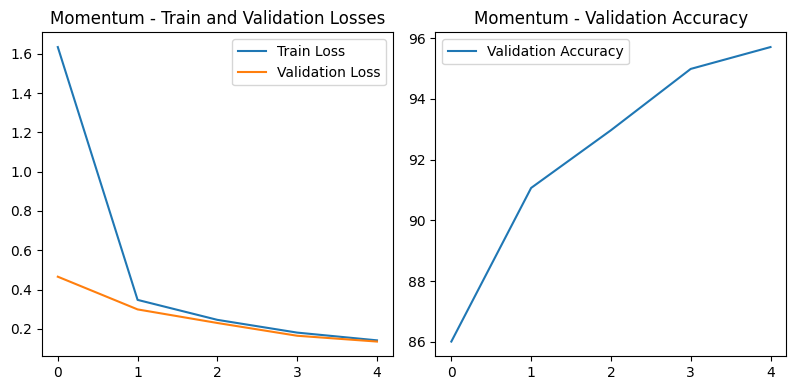

Epoch: 1/5, Train Loss: 0.2195, Validation Loss: 0.0946, Validation Accuracy: 96.93%
Epoch: 2/5, Train Loss: 0.0628, Validation Loss: 0.0856, Validation Accuracy: 97.50%
Epoch: 3/5, Train Loss: 0.0418, Validation Loss: 0.0463, Validation Accuracy: 98.59%
Epoch: 4/5, Train Loss: 0.0322, Validation Loss: 0.1111, Validation Accuracy: 96.48%
Epoch: 5/5, Train Loss: 0.0247, Validation Loss: 0.0394, Validation Accuracy: 98.88%
Training using RMSProp with BatchNorm=False took 37.95 seconds.


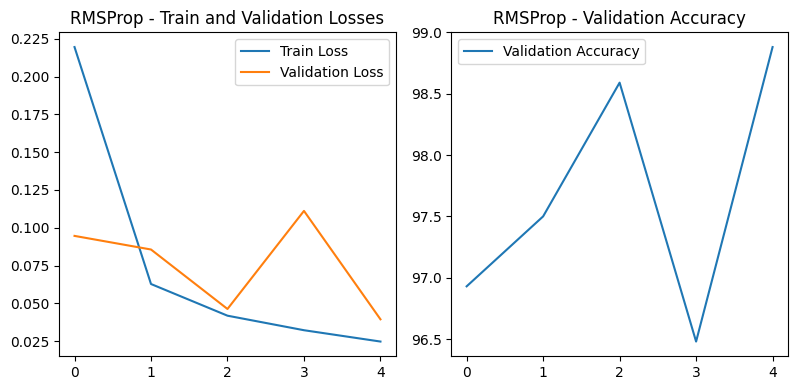

Epoch: 1/5, Train Loss: 0.1728, Validation Loss: 0.0818, Validation Accuracy: 97.76%
Epoch: 2/5, Train Loss: 0.0500, Validation Loss: 0.0452, Validation Accuracy: 98.60%
Epoch: 3/5, Train Loss: 0.0340, Validation Loss: 0.0397, Validation Accuracy: 98.83%
Epoch: 4/5, Train Loss: 0.0239, Validation Loss: 0.0440, Validation Accuracy: 98.78%
Epoch: 5/5, Train Loss: 0.0196, Validation Loss: 0.0471, Validation Accuracy: 98.73%
Training using Adam with BatchNorm=False took 38.98 seconds.


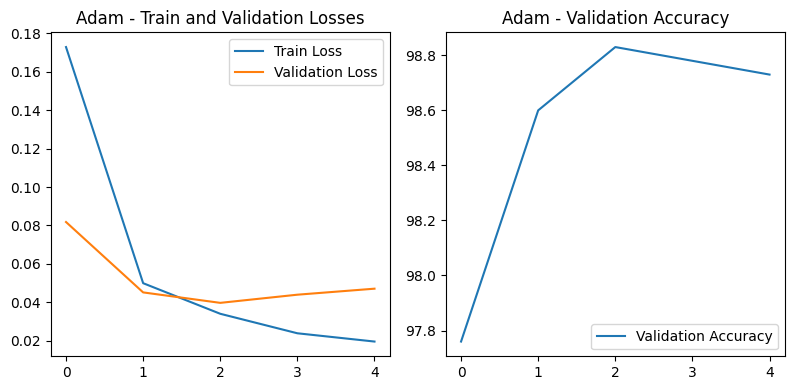

In [13]:
for opt in optimizer_types:
    accuracy, class_report, conf_matrix, _ = train_and_evaluate(opt)
    results[opt] = {
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    }

## Comparitive performance of the 4 optimizers on the test set

In [14]:
def display_results(optimizer_type, results):
    """
    Display accuracy, test loss, classification report, and a heatmap for the confusion matrix.
    """
    print(f"\nResults for {optimizer_type} optimizer:")
    print(f"Accuracy: {results['Accuracy']:.2f}%")
    print(f"\nClassification Report:\n{results['Classification Report']}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {optimizer_type} optimizer")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### SGD Performance


Results for SGD optimizer:
Accuracy: 81.11%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       980
           1       0.89      0.95      0.92      1135
           2       0.85      0.82      0.84      1032
           3       0.74      0.88      0.80      1010
           4       0.75      0.80      0.77       982
           5       0.86      0.61      0.71       892
           6       0.84      0.87      0.85       958
           7       0.84      0.83      0.83      1028
           8       0.79      0.67      0.73       974
           9       0.72      0.71      0.71      1009

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



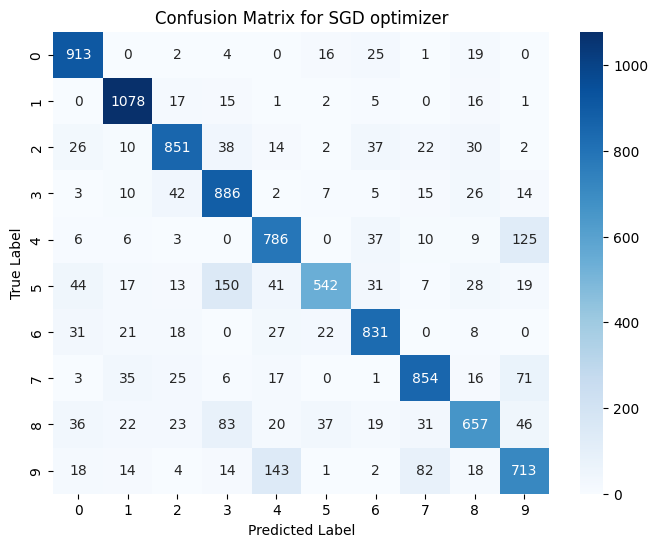

In [15]:
display_results("SGD", results["SGD"])

### Momentum Performance


Results for Momentum optimizer:
Accuracy: 96.51%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.94      0.98      0.96       892
           6       0.98      0.96      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.94      0.95      0.95       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.96      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000



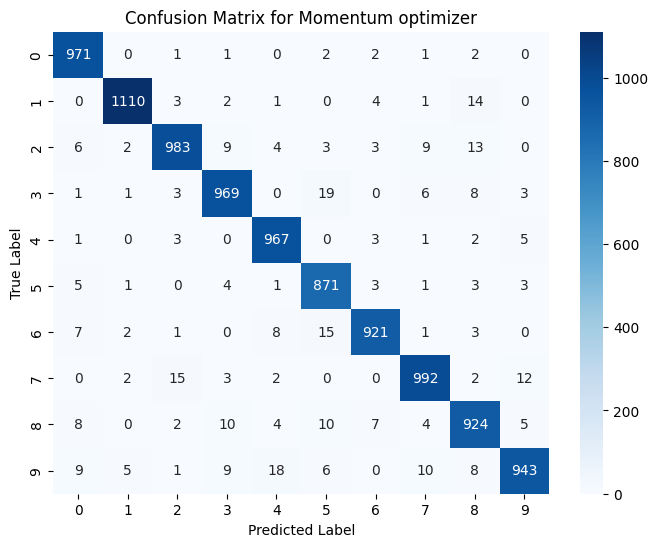

In [16]:
display_results("Momentum", results["Momentum"])

### RMSProp Performance


Results for RMSProp optimizer:
Accuracy: 98.93%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



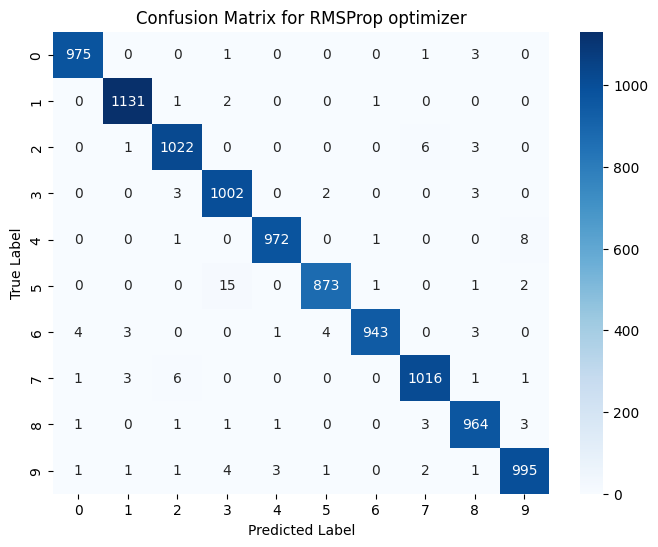

In [17]:
display_results("RMSProp", results["RMSProp"])

### Adam Performance


Results for Adam optimizer:
Accuracy: 99.03%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



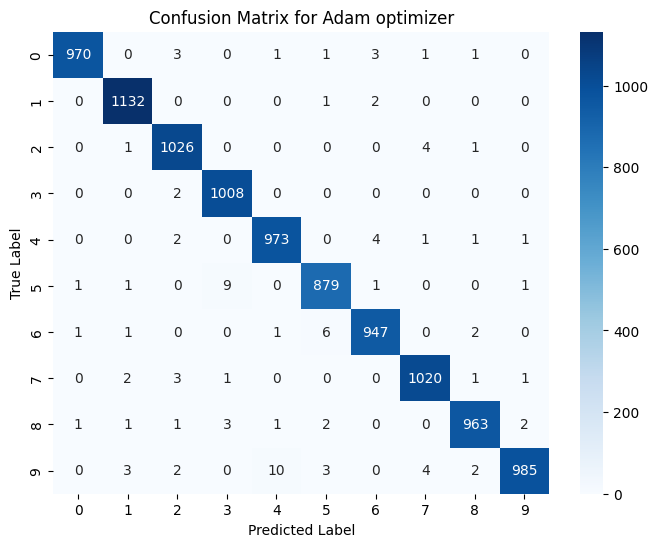

In [18]:
display_results("Adam", results["Adam"])

## Saving the best model

In [20]:
# Save the best model
save_path = "/content/drive/MyDrive/EE5179/best_model_new_checkpoint/best_model_with_{}_optimizer.pth".format(best_optimizer)
torch.save(best_model.state_dict(), save_path)
print(f"Best model saved to Google Drive with {best_optimizer} optimizer, achieved accuracy: {best_accuracy:.2f}%")

Best model saved to Google Drive with Adam optimizer, achieved accuracy: 99.03%


# Best Model Performance

In [21]:
top_model = SimpleCNN()
top_model.load_state_dict(torch.load(save_path))
top_model.eval()

SimpleCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

## Plot of training error, validation error and prediction accuracy as the training progresses.

Training done for 5 epochs with a learning rate of 0.001, momentum of 0.9 (wherever applicable), no batch nomralization with A100 GPU on Google Colab. \

Optimizer | Test Accuracy | Time taken to train (s) |
-------------------|------------------|---------------|
      SGD |  81.11% |  45.65  |
        Momentum | 96.51% | 37.86  |
       RMSProp |  98.93% | 37.95  |
       Adam | 99.03% | 38.98  |


The performance of Adam and RMSProp is comparable. Additonally, we don't need as many as 5 epochs with optimziers other than naive SGD to get a good accuracy; fewer epochs are enough. We also see that performance and training time both improve when we train with momentum. Training time for Momentum, RMSProp, and Adam is almost the same, however, one might say the Monentum is faster than the others because the other two optimizers have a higher computational load:


1.   Momentum: Requires the maintenance and update of a momentum term for each parameter.
2.   RMSProp: In addition to the momentum term, it also keeps a moving average of squared gradients.
3. Adam: Combines aspects of both Momentum and RMSProp, maintaining both momentum terms and moving averages of squared gradients

Due to the extra operations required for RMSProp and Adam, each epoch might take slightly longer to run when compared to Momentum. Although, this difference is small for this simple dataset, it might appear in more aggaravted fashion for more complex data.



Even though Adam and RMSProp are competitive, we porceed with Adam as the optimizer for best performance because it has outperformed RMSProp on several tasks in literature. [1][2]


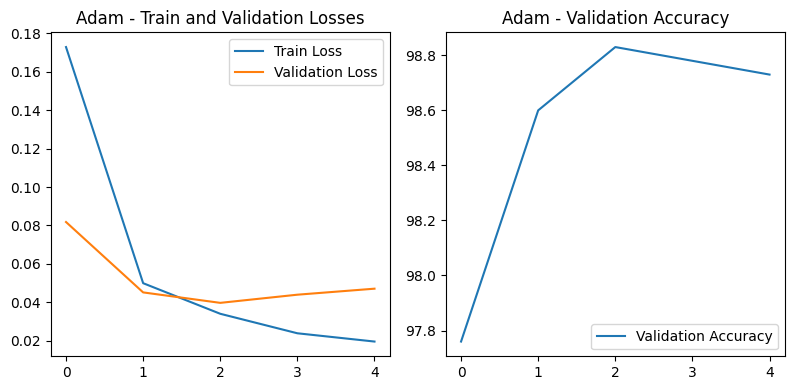

However, the plots for Adam don't give a good idea about training as there is a lack of stability in the small range of loss (0-0.18) and validation accuracy (97.79% to 98.93%) Hence, we look at the plot for SGD which gives a better idea as the larger range of loss values and validation accuracy lead to smoother curves.

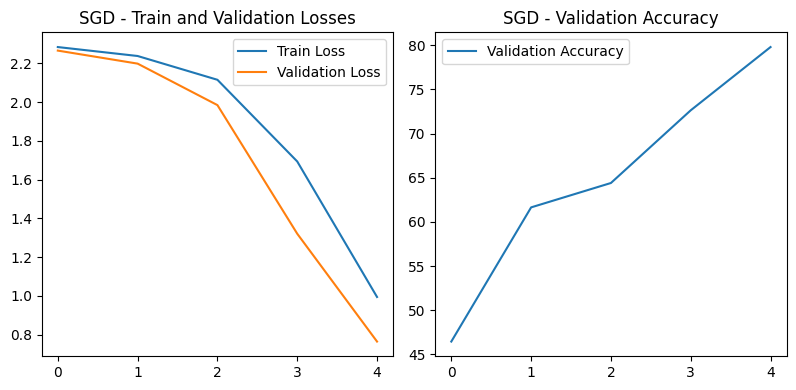

As expected, we see that, both train and validation loss values keep decreasing while training. \

[1] D. Choi, C. J. Shallue, Z. Nado, J. Lee, C. J. Maddison, and G. E. Dahl, "On Empirical Comparisons of Optimizers for Deep Learning," arXiv preprint arXiv:1910.05446, 2020. \
[2] R. M. Schmidt, F. Schneider, and P. Hennig, "Descending through a Crowded Valley - Benchmarking Deep Learning Optimizers," in *Proceedings of the 38th International Conference on Machine Learning*, M. Meila and T. Zhang, Eds., vol. 139, PMLR, Jul. 2021, pp. 9367-9376. [Online]. Available: http://proceedings.mlr.press/v139/schmidt21a.html


## Accuracy and Performance with top model


Results for Adam optimizer:
Accuracy: 99.03%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



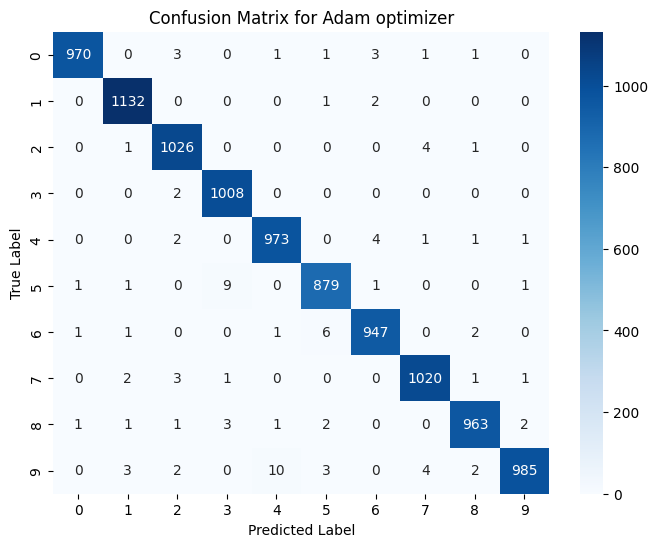

In [22]:
display_results("Adam", results["Adam"])

## Plotting Random Samples

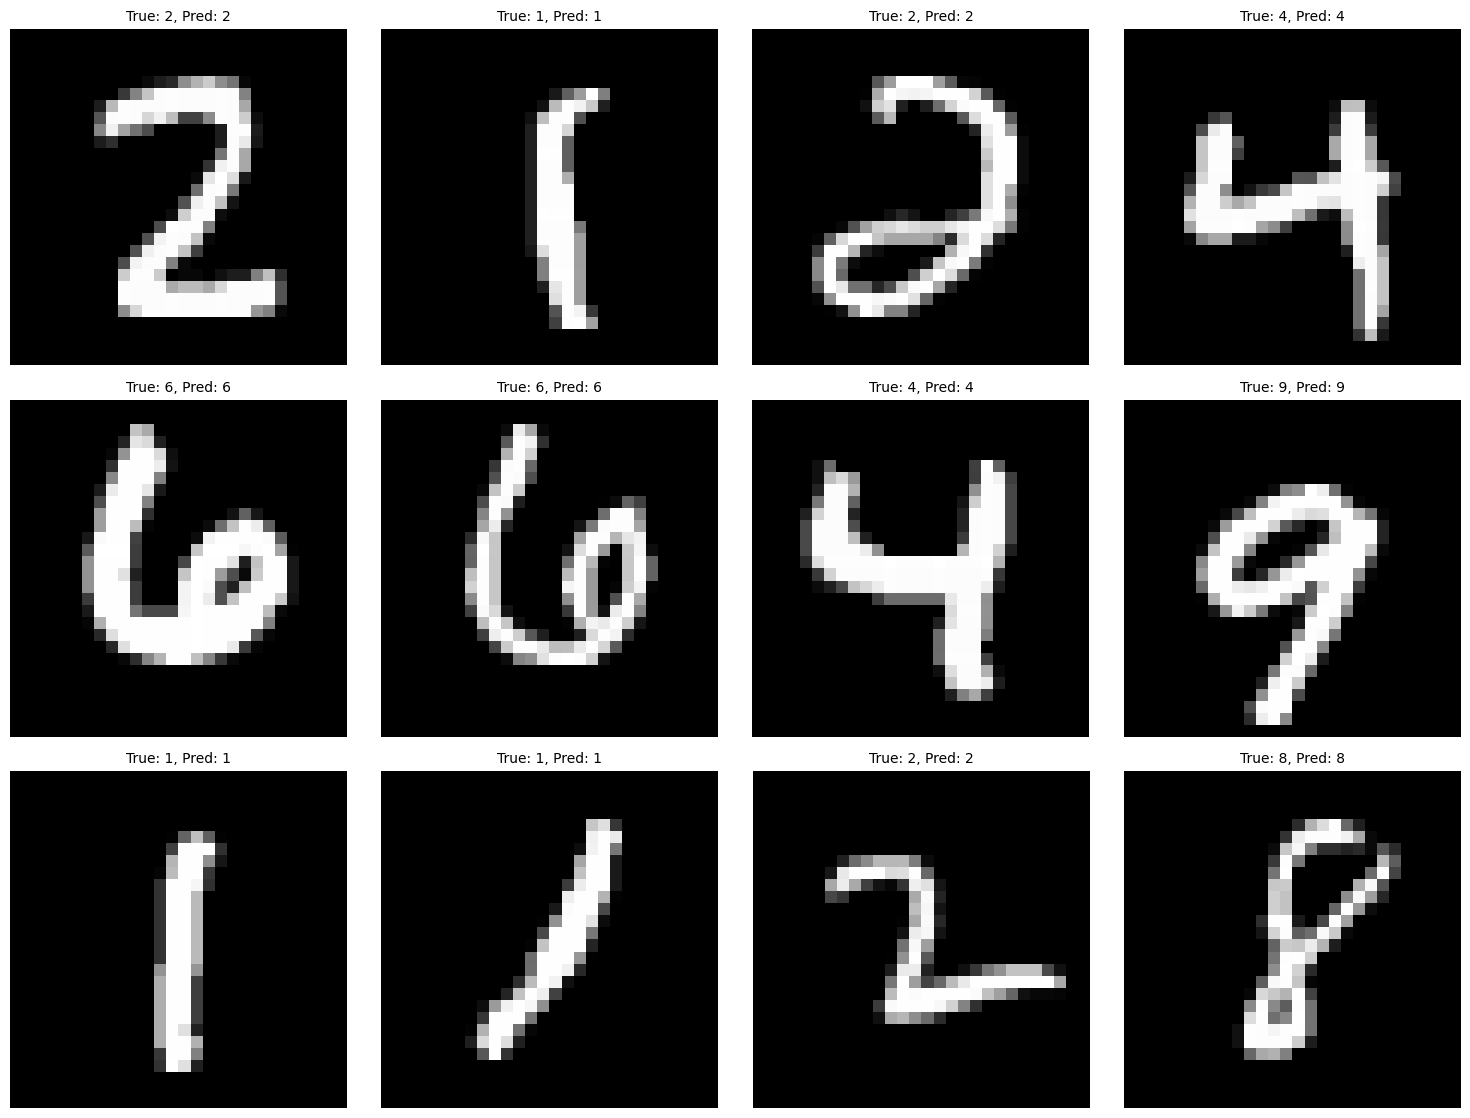

In [23]:
top_model = top_model.to(device)
plot_predictions(top_model, test_loader)

## Layer-wise dimensions

In [24]:
summary(top_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 500]         784,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 3.05
Estimated Total Size (MB): 3.60
-------------------------------------------

## Number of parameters and neurons

In [25]:
count_parameters_and_neurons(top_model)

Total parameters: 9568
Parameters in FC layers: 0
Parameters in Conv layers: 9568
Total neurons: 31360
Neurons in FC layers: 0
Neurons in Conv layers: 31360
Total parameters: 789510
Parameters in FC layers: 789510
Parameters in Conv layers: 0
Total neurons: 510
Neurons in FC layers: 510
Neurons in Conv layers: 0
Total parameters: 799078
Parameters in FC layers: 789510
Parameters in Conv layers: 9568
Total neurons: 31870
Neurons in FC layers: 510
Neurons in Conv layers: 31360


{'total_parameters': 799078,
 'fc_parameters': 789510,
 'conv_parameters': 9568,
 'total_neurons': 31870,
 'fc_neurons': 510,
 'conv_neurons': 31360}

### Answering Q4 and Q5 of Part 1
Total number of parameters: 799078 \
Number of parameters in FC layers: 789510 \
Number of parameters in convolution layers: 9568 \
Total number of neurons: 31870\
Number of neurons in FC layers: 510 \
Number of neurons in convolution layers: 31360 \

# Training with Batch Normalization
Since, Adam already acheieves very good performance in 5 epochs without batch normalization (99.03%), we might not be able to comment objectively on the change in performance when batch normalization is used. Hence, we test if performance improves when we add Batch Normalization to SGD for training.

Epoch: 1/5, Train Loss: 0.8252, Validation Loss: 0.4271, Validation Accuracy: 91.44%
Epoch: 2/5, Train Loss: 0.3302, Validation Loss: 0.2773, Validation Accuracy: 94.00%
Epoch: 3/5, Train Loss: 0.2331, Validation Loss: 0.2138, Validation Accuracy: 95.23%
Epoch: 4/5, Train Loss: 0.1856, Validation Loss: 0.1776, Validation Accuracy: 95.82%
Epoch: 5/5, Train Loss: 0.1566, Validation Loss: 0.1541, Validation Accuracy: 96.41%
Training using SGD with BatchNorm=True took 39.25 seconds.


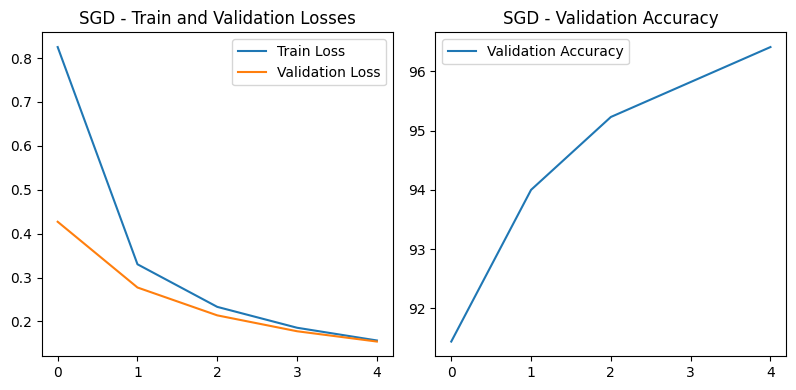

In [26]:
sgd_bn_acc, sgd_bn_cr, sgd_bn_cm, sgd_bn_model = train_and_evaluate(optimizer_type = "SGD", use_batch_norm=True, update_best_model=False)
sgd_bn_results = {
        "Accuracy": sgd_bn_acc,
        "Classification Report": sgd_bn_cr,
        "Confusion Matrix": sgd_bn_cm
    }


Results for SGD optimizer:
Accuracy: 96.83%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.96      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



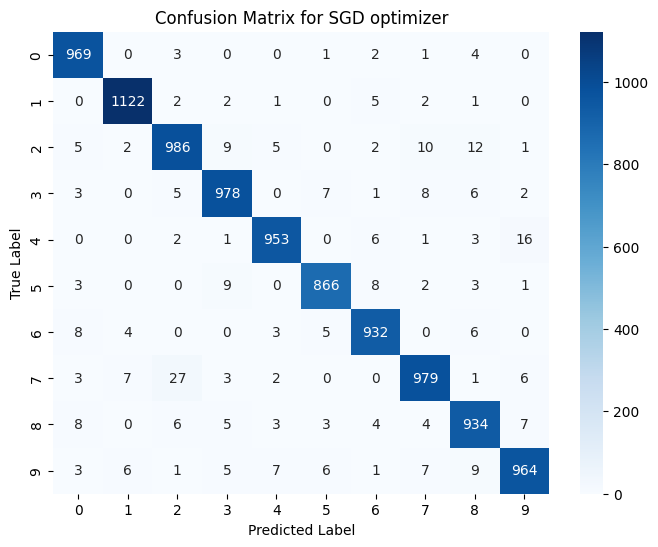

In [27]:
display_results(optimizer_type = "SGD", results = sgd_bn_results)

In [ ]:
summary(sgd_bn_model, input_size=(1, 28, 28))

# Performance with and without Batch Normalization

Batch Normalization | Test Accuracy | Time taken to train (s) | Number of Parameters |
-------------------|------------------|---------------|--------------|
      No |  81.11% | 45.65 | 799,078 |
     Yes | 96.83% | 39.25  | 800,206 |

Test Accuracy sees a significant improvement when batch normalization is used with SGD for training. Training time is more, because there are more parameters involved. Faster convergence can be expected with Batch Normalization when training with more epochs based on the loss plots. Training is also faster with Batch normalization, potenitally because of lesser sensitivity to initialization and more stabilized activation distributions. What's interesting is without Bathcnorm, the training loss after 5 epochs is close to 0.99, which is more than the training loss (0.83) with batch normalization after just one epoch, showing the importance of initialization, the sensitivity of SGD to it and its impact.

Based on this empirical evidence, we can assume that Adam will also perform better with Batch Normalization on an average across different splits of the dataset and/or for more complex datasets. Hence, we'll train the model with Batch Normalization and Adam as the optimizer for the tasks ahead.
       

# Adam + Batch Normalization

Epoch: 1/5, Train Loss: 0.0892, Validation Loss: 0.0597, Validation Accuracy: 98.27%
Epoch: 2/5, Train Loss: 0.0358, Validation Loss: 0.0406, Validation Accuracy: 98.81%
Epoch: 3/5, Train Loss: 0.0224, Validation Loss: 0.0436, Validation Accuracy: 98.78%
Epoch: 4/5, Train Loss: 0.0178, Validation Loss: 0.0413, Validation Accuracy: 98.74%
Epoch: 5/5, Train Loss: 0.0135, Validation Loss: 0.0390, Validation Accuracy: 98.91%
Training using Adam with BatchNorm=True took 39.96 seconds.


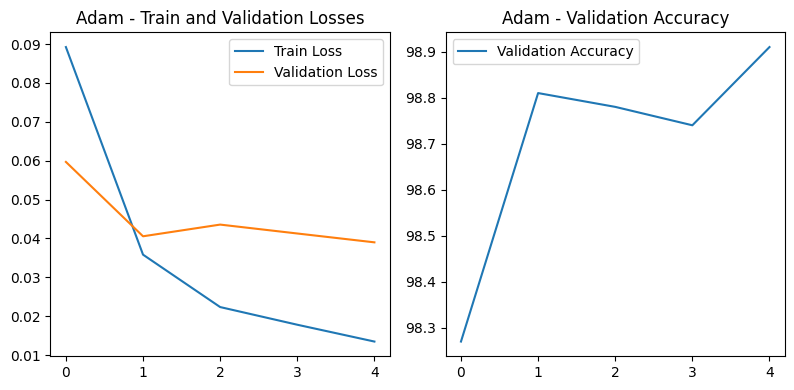

In [28]:
adam_bn_acc, adam_bn_cr, adam_bn_cm, adam_bn_model = train_and_evaluate(optimizer_type = "Adam", use_batch_norm=True, update_best_model=False)
adam_bn_results = {
        "Accuracy": adam_bn_acc,
        "Classification Report": adam_bn_cr,
        "Confusion Matrix": adam_bn_cm
    }


Results for Adam optimizer:
Accuracy: 98.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



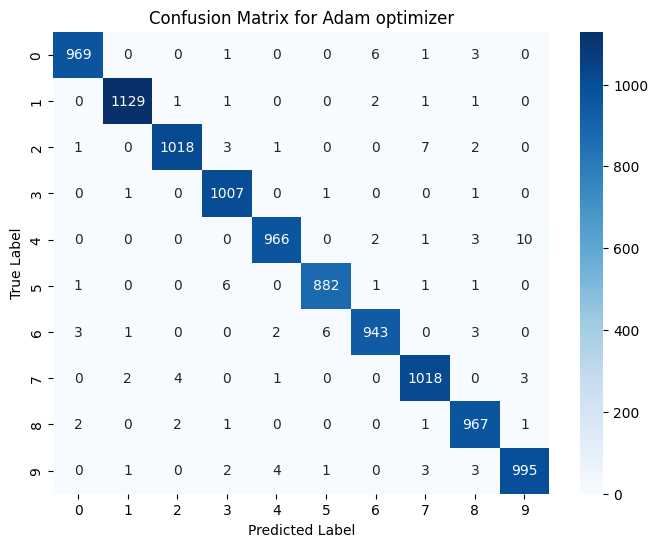

In [29]:
display_results(optimizer_type = "Adam", results = adam_bn_results)

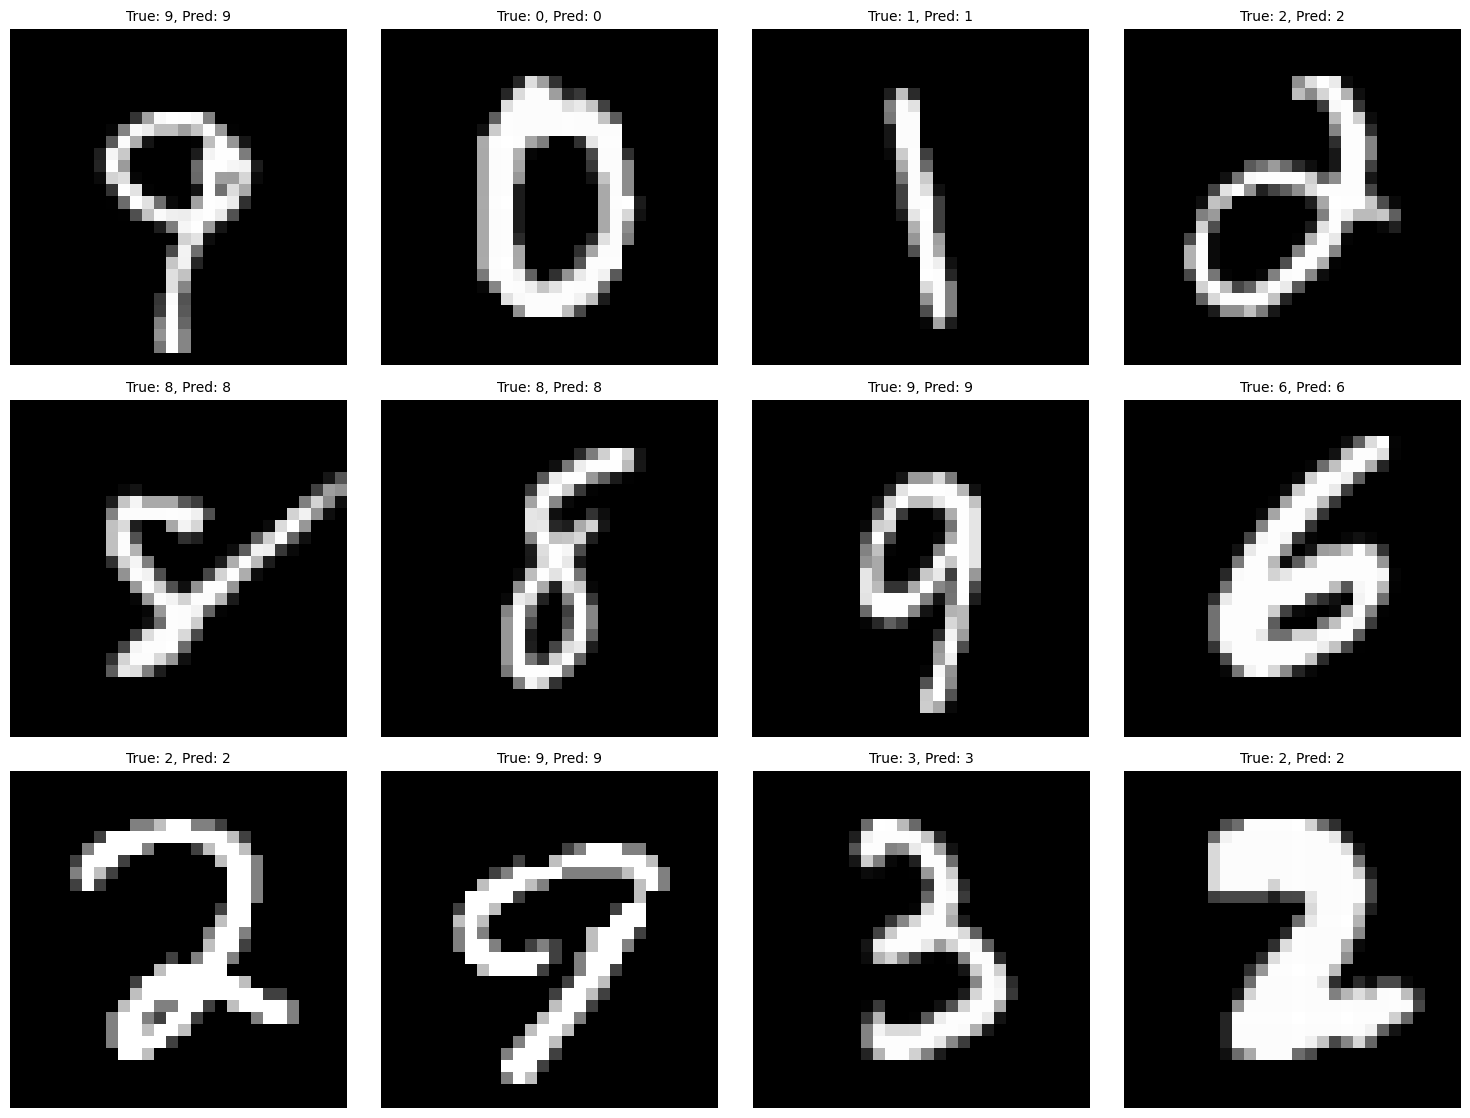

In [30]:
plot_predictions(adam_bn_model, test_loader)

# Plotting the filters

In [31]:
def plot_filters(model, layer_num, num_columns=8):
    layer = dict(model.conv_block.named_children())[str(layer_num)]

    filters = layer.weight.data.cpu()

    num_filters = filters.shape[0]
    num_rows = int(np.ceil(num_filters / num_columns))

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

    for i in range(num_filters):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]
        ax.imshow(filters[i, 0, :, :], cmap="gray")
        ax.axis('off')

    for j in range(num_filters, num_rows * num_columns):
        row = j // num_columns
        col = j % num_columns
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

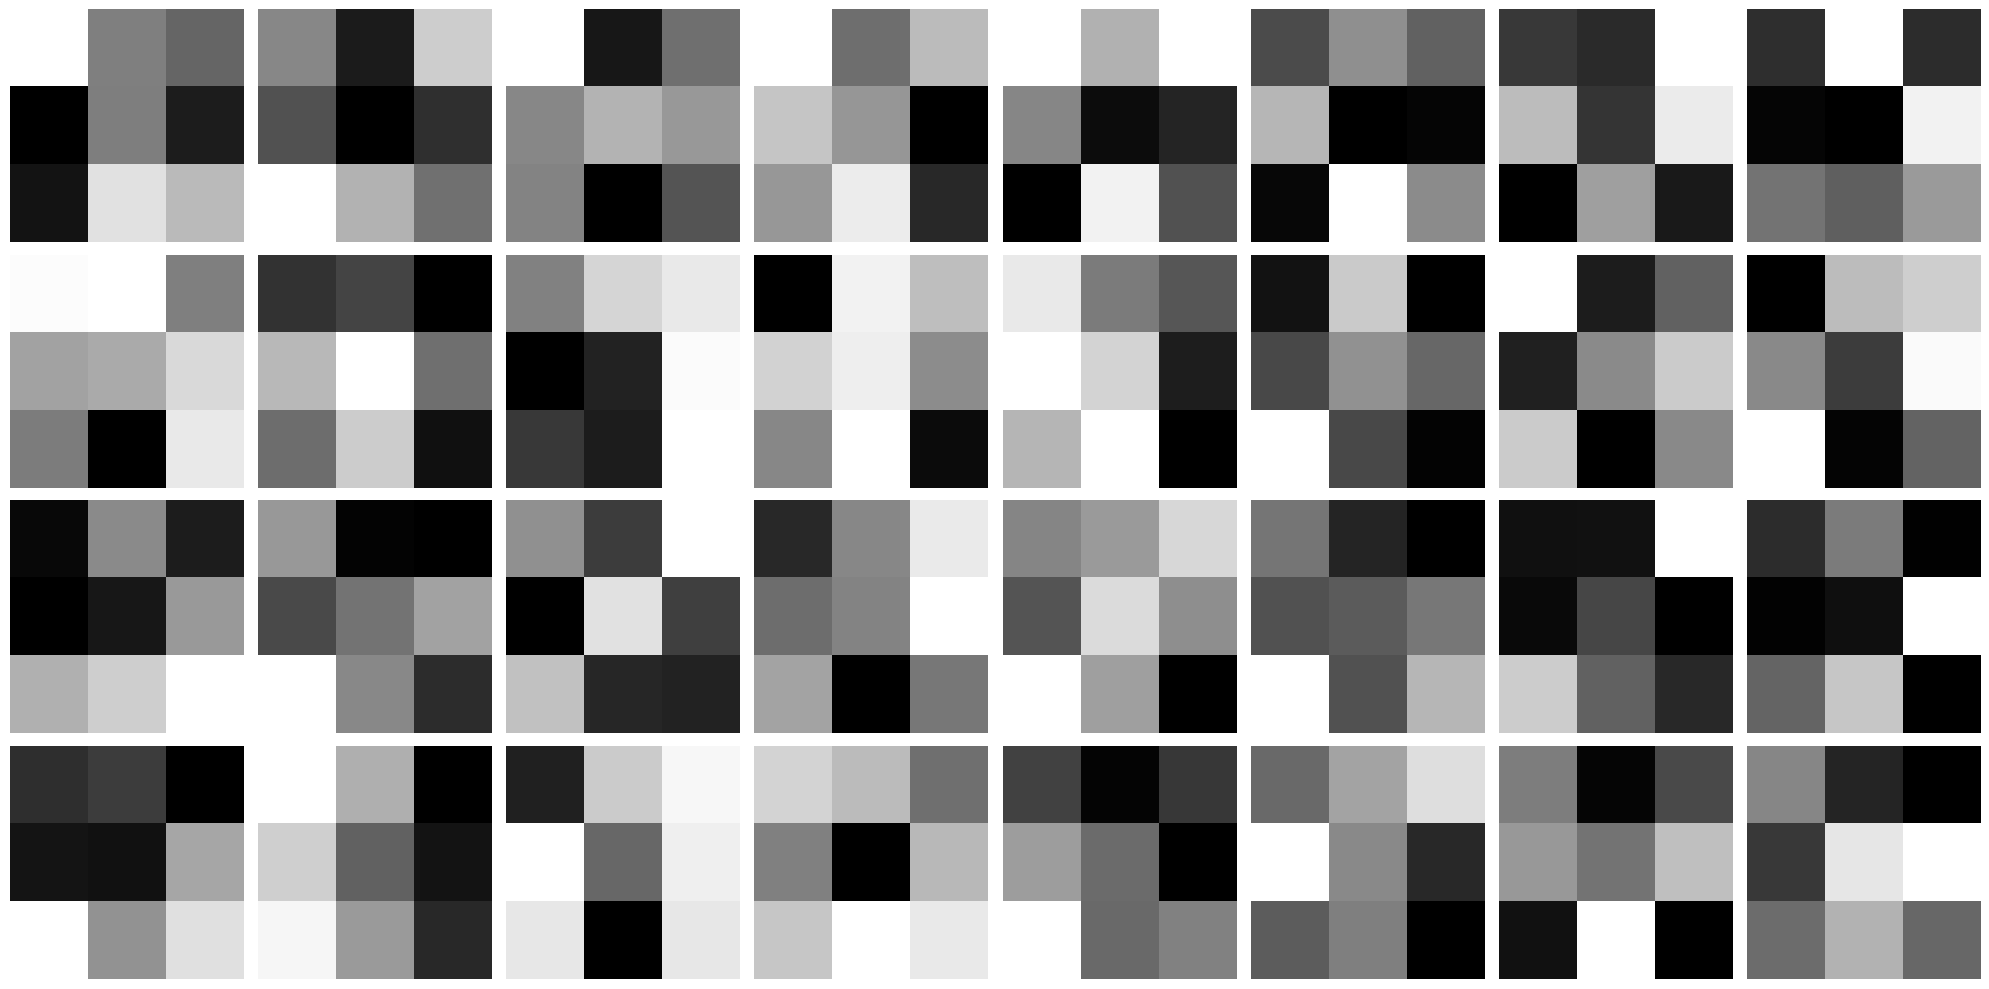

In [32]:
plot_filters(sgd_bn_model, 0)

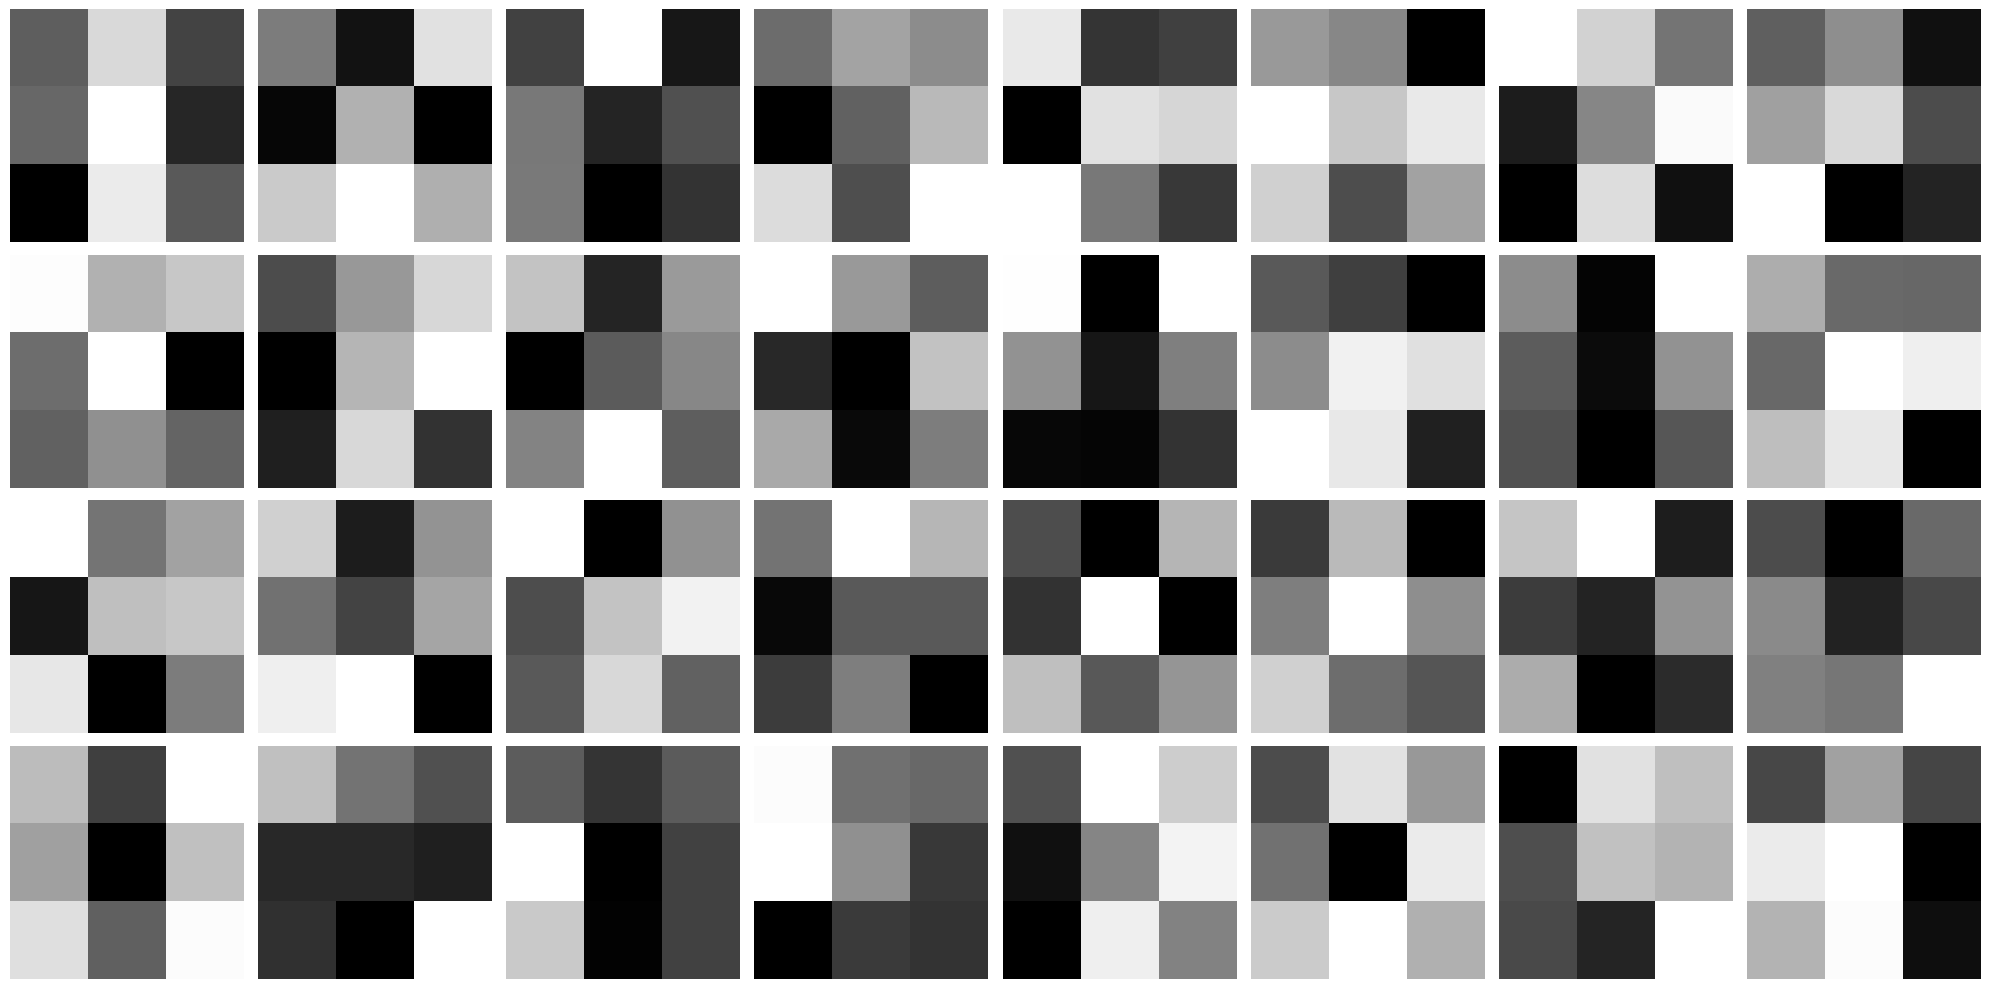

In [33]:
plot_filters(sgd_bn_model, 4)

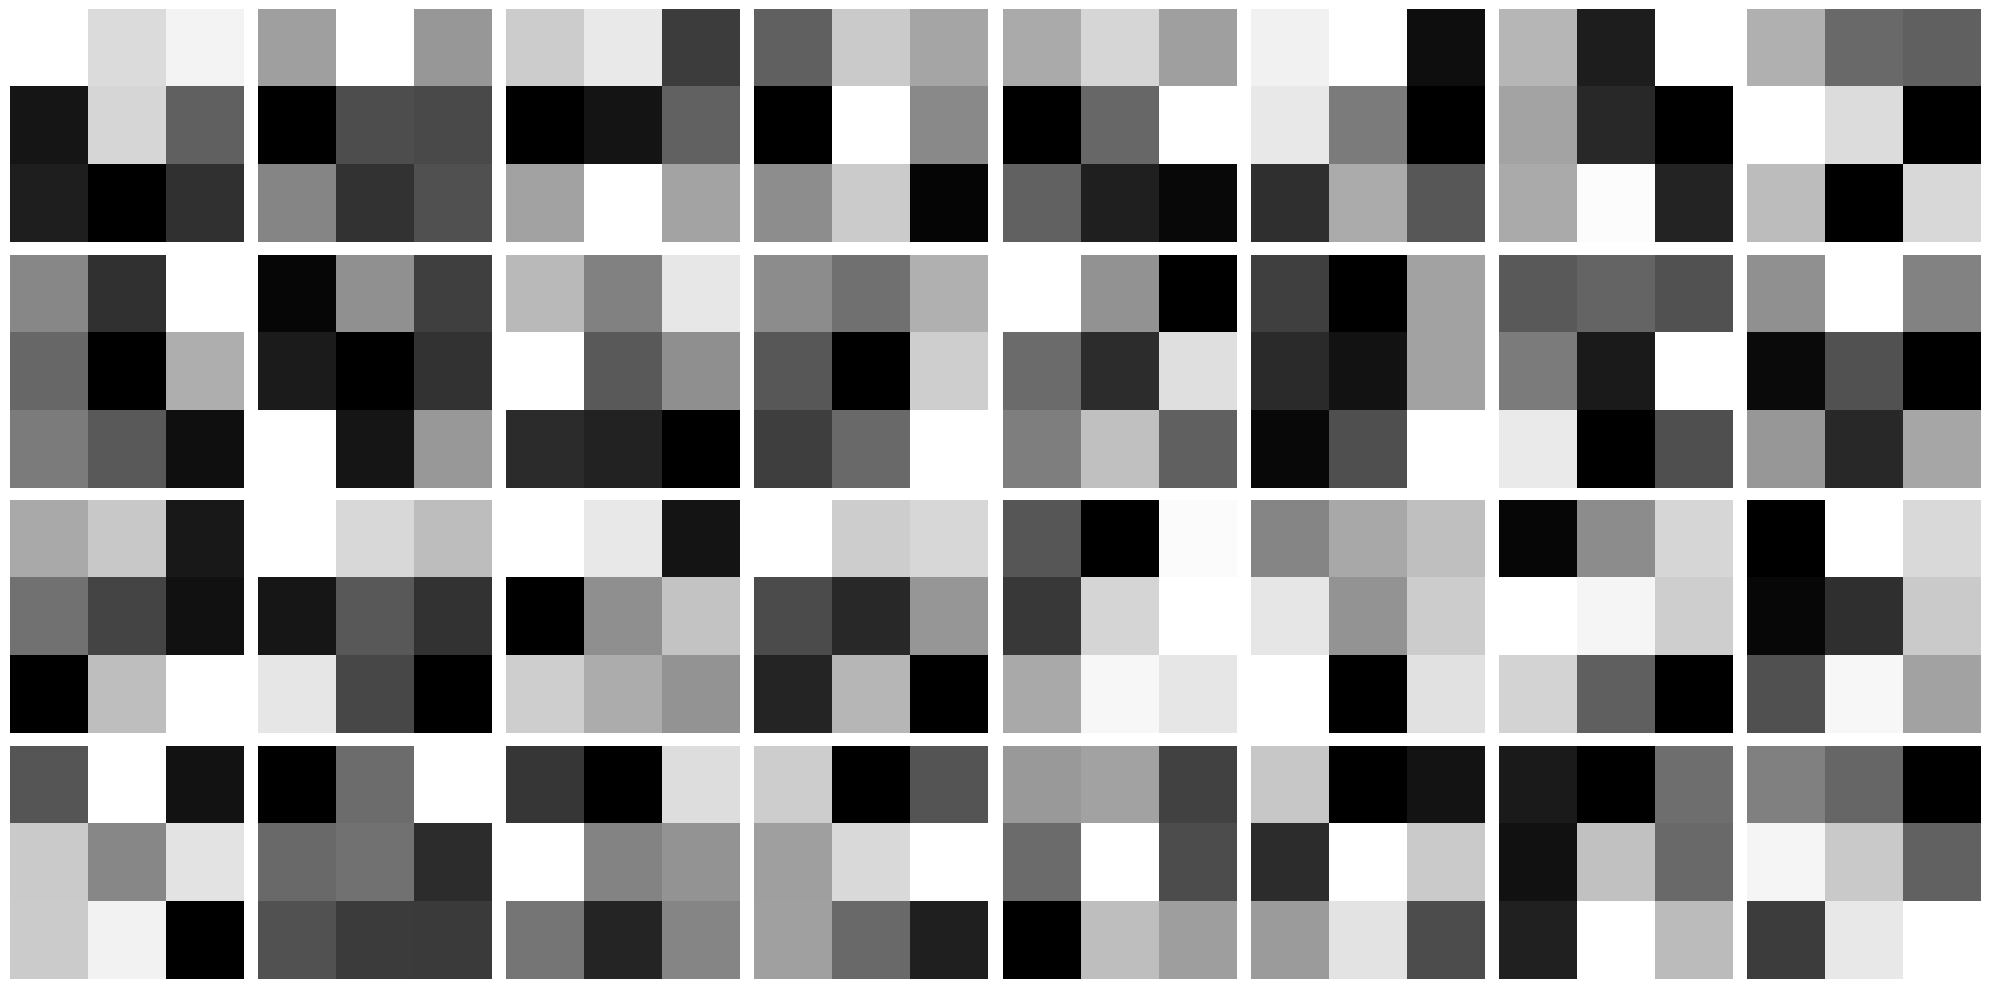

In [34]:
plot_filters(adam_bn_model, 0)

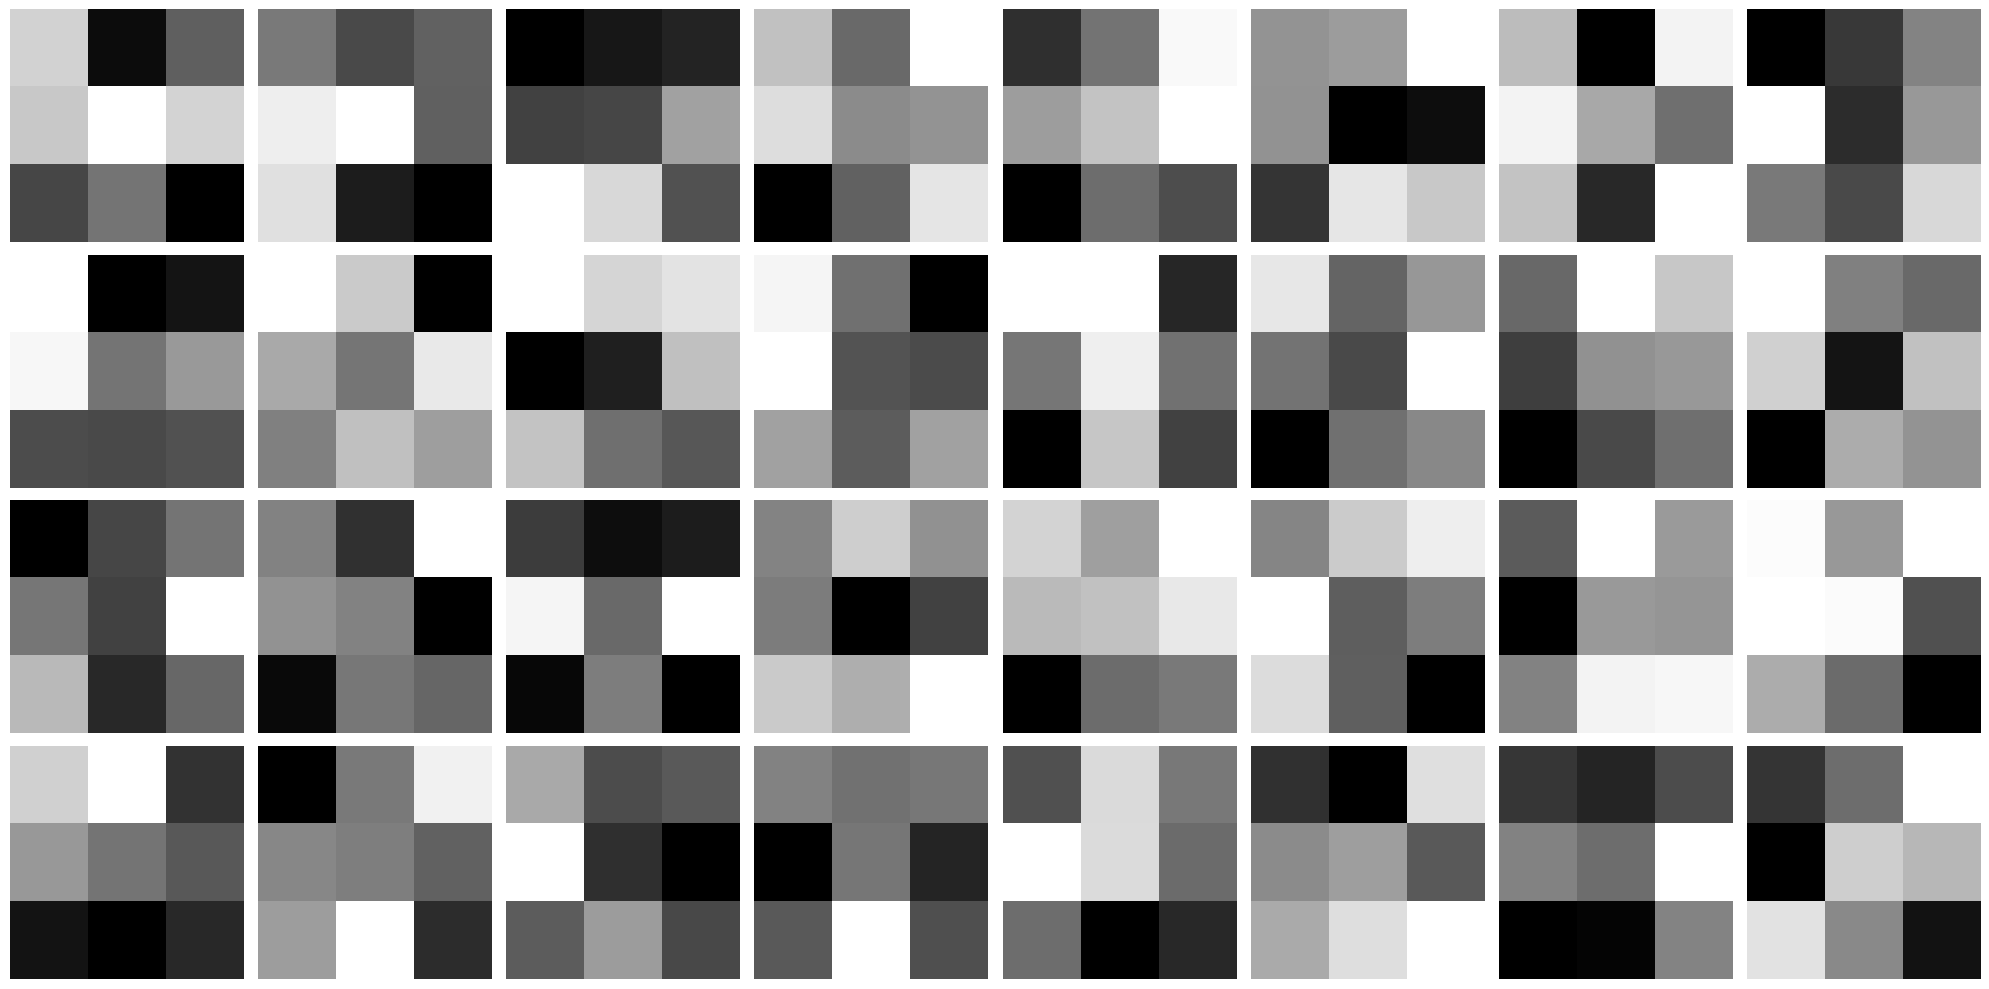

In [35]:
plot_filters(adam_bn_model, 4)

## Comments:


1.   In the first layer, we often see filters transitioning from white to black in a horizontal, vertical or diagonal direction, meaning it is probably capturing edges in the image. These are supposed to be low-level feature extractors and are looking for edges or simple patterns in the images.
2.   Filters from deeper layers tend to capture more abstract patterns and do not seem to be as interpretable as the first layer.

We should probably plot the activations of both layers to visualize the feature maps of an image and try to infer what's happening there.



# Plotting the activations

In [36]:
def plot_activations(model, image, layer_num, num_columns=8):
    activations = []
    def hook(module, input, output):
        activations.append(output)

    layer = dict(model.conv_block.named_children())[str(layer_num)]
    handle = layer.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        model(image.unsqueeze(0))
    model.train()

    handle.remove()

    act = activations[0].squeeze().cpu().detach().numpy()

    num_filters = act.shape[0]
    num_rows = int(np.ceil(num_filters / num_columns))

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

    for i in range(num_filters):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]
        ax.imshow(act[i], cmap="gray")
        ax.axis('off')

    for j in range(num_filters, num_rows * num_columns):
        row = j // num_columns
        col = j % num_columns
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return act

In [37]:
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

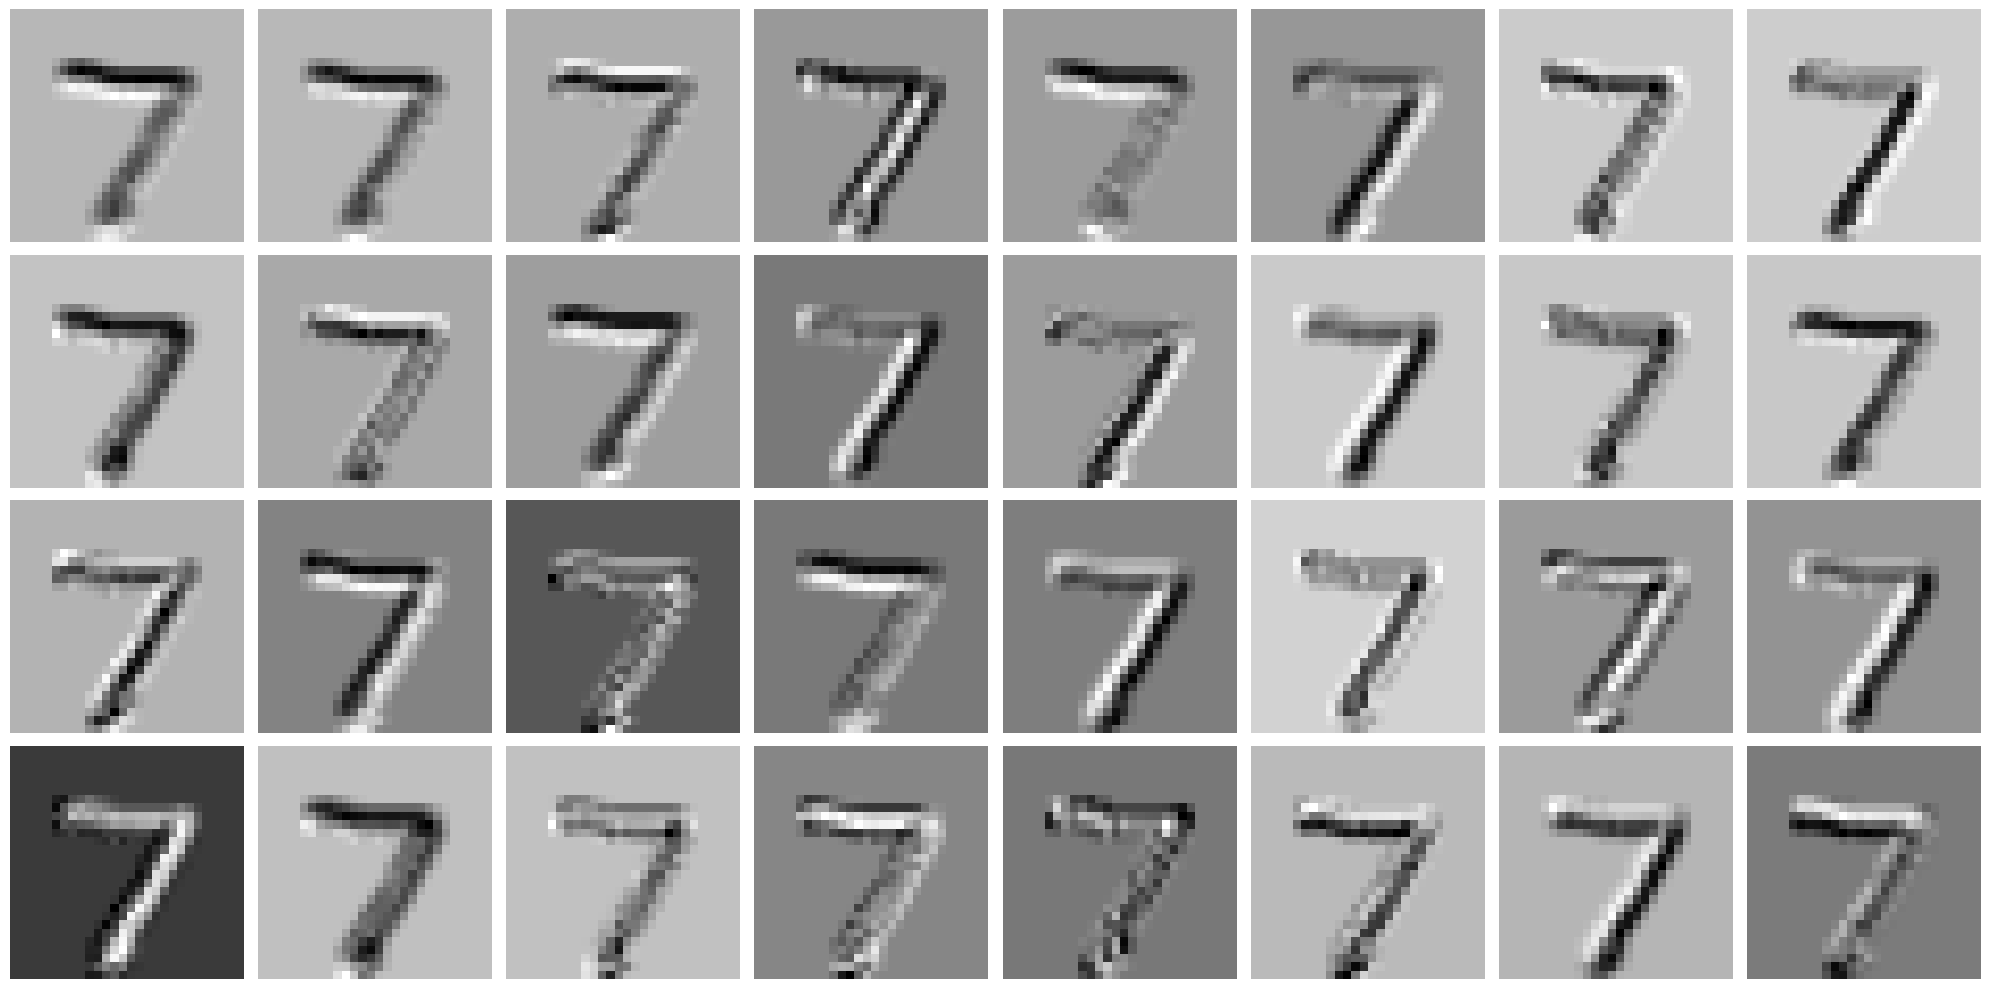

In [38]:
activation_val_conv1 = plot_activations(model=adam_bn_model, image=sample_img[0], layer_num=0)

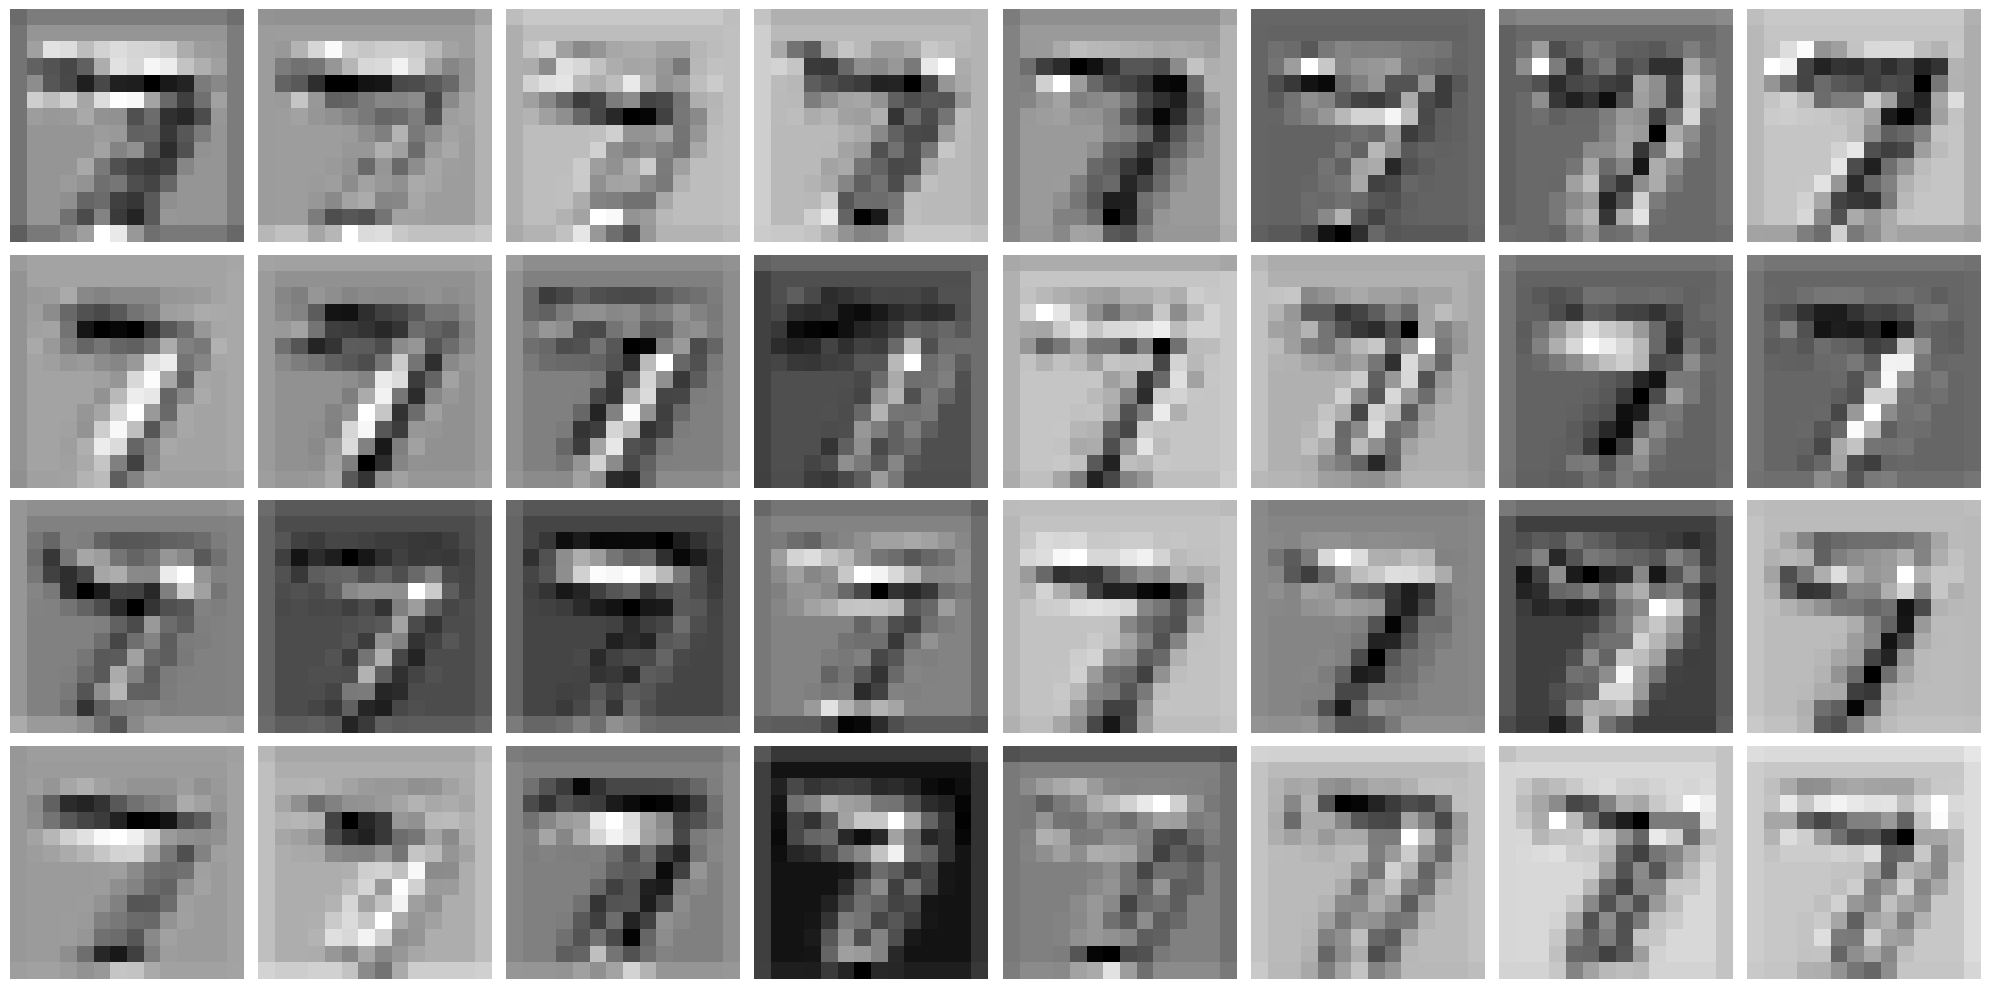

In [39]:
activation_val_conv2 = plot_activations(model=adam_bn_model, image=sample_img[0], layer_num=4)

From the activations, we can see that the network learns complex and abstract patterns as we go deeper. The activation maps of the first layer's filters have smoother edges and are more well-defined, signifying the fact that it is trying to capture edges and simpler features/patterns.

# Occlusion Experiment

In [40]:
def occlusion(model, image, label, occ_size=5, occ_stride=1, occ_pixel=0.5):

    width, height = image.shape[-2], image.shape[-1]

    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))

    heatmap = torch.zeros((output_height, output_width))

    for h in range(0, height):
        for w in range(0, width):

            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)

            if (w_end) >= width or (h_end) >= height:
                continue

            input_image = image.clone().detach()

            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel

            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]

            heatmap[h, w] = prob

    return heatmap

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def visualize_occlusion(model, test_loader, num_images=10, occ_size=5):
    model.eval()

    fig, ax = plt.subplots(num_images, 2, figsize=(12, 3 * num_images))

    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)

        for i in range(num_images):
            r = i
            c = 0

            image = images[i:i+1]
            label = labels[i]


            _, predicted = torch.max(model(image).data, 1)

            heatmap = occlusion(model, image, label.item(), occ_size=occ_size)

            ax[r, c].imshow(image.cpu().squeeze().numpy(), cmap='gray')
            ax[r, c].set_title(f'Predicted: {predicted.item()} Actual: {label.item()}')

            im = ax[r, c+1].imshow(heatmap, cmap='hot', interpolation='nearest')

            divider = make_axes_locatable(ax[r, c+1])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()

## Occlusion Filter Size = 1

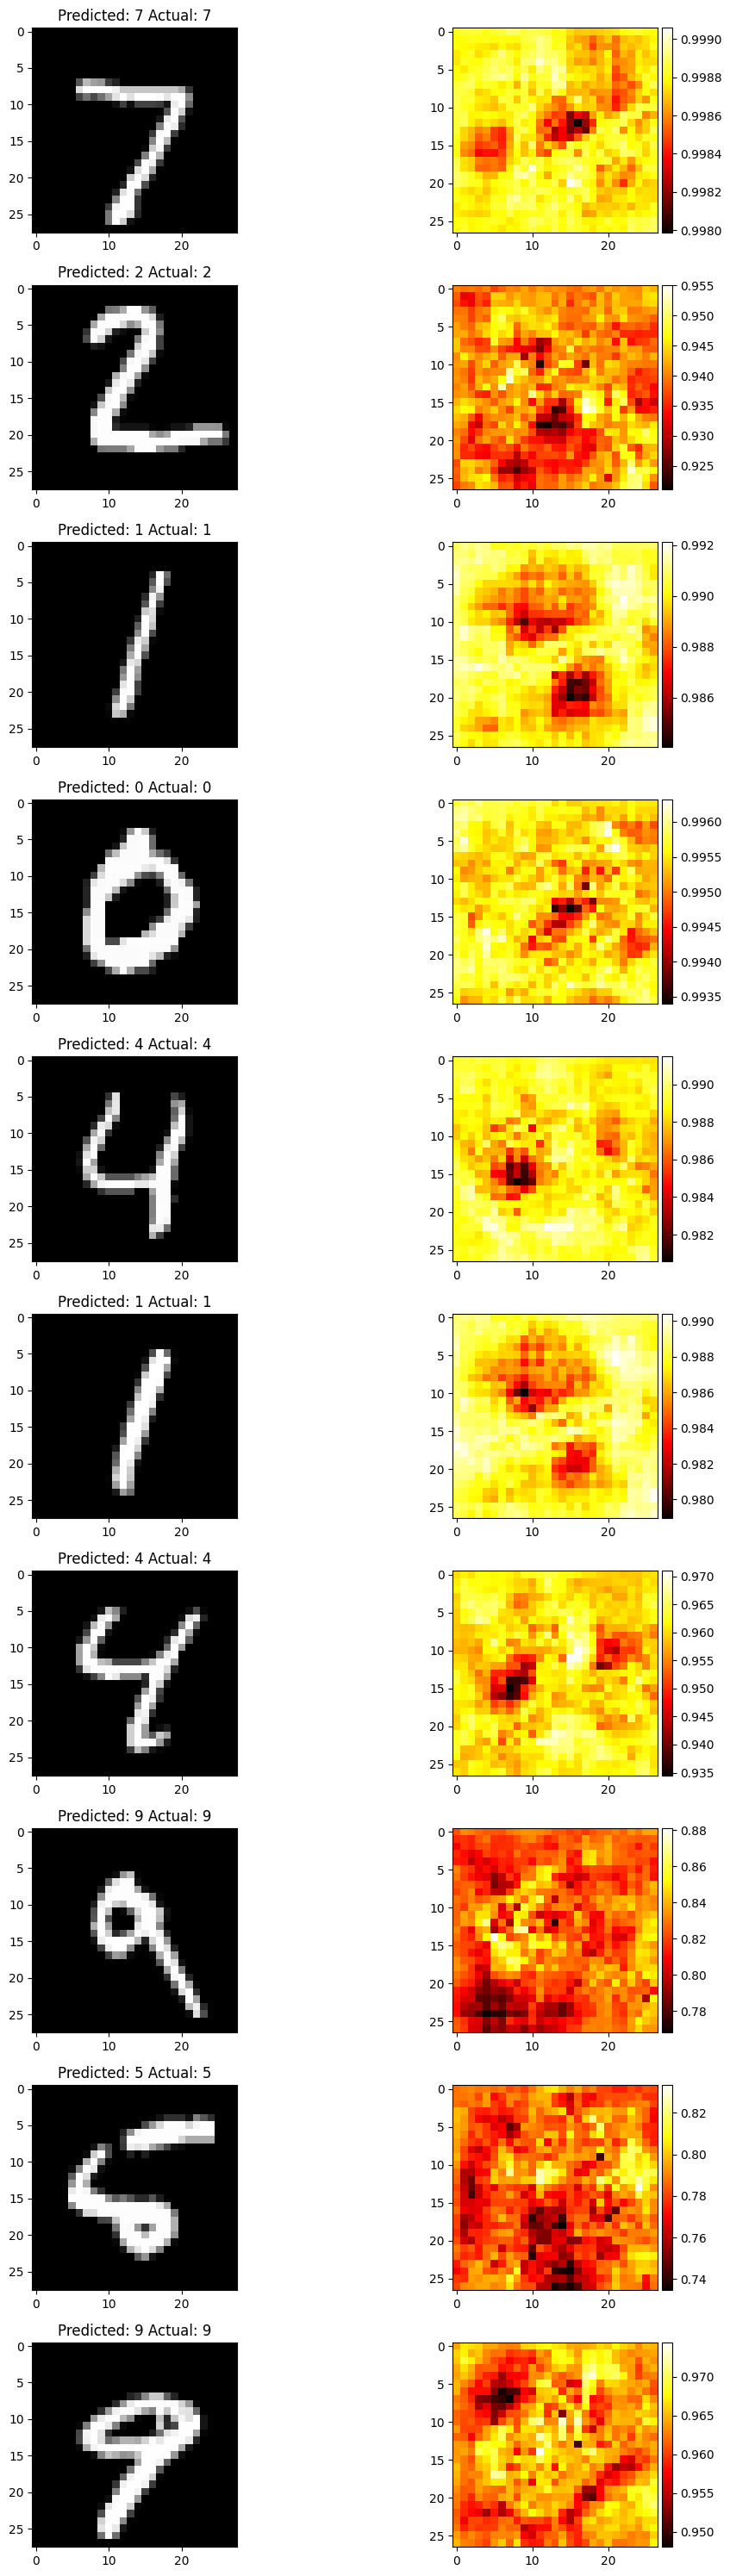

In [47]:
sgd_bn_model = sgd_bn_model.to(device)
visualize_occlusion(sgd_bn_model, test_loader, num_images = 10, occ_size = 1)

WIth this small filter, the model is still pretty confident in most cases.

## Occlusion Filter Size = 3

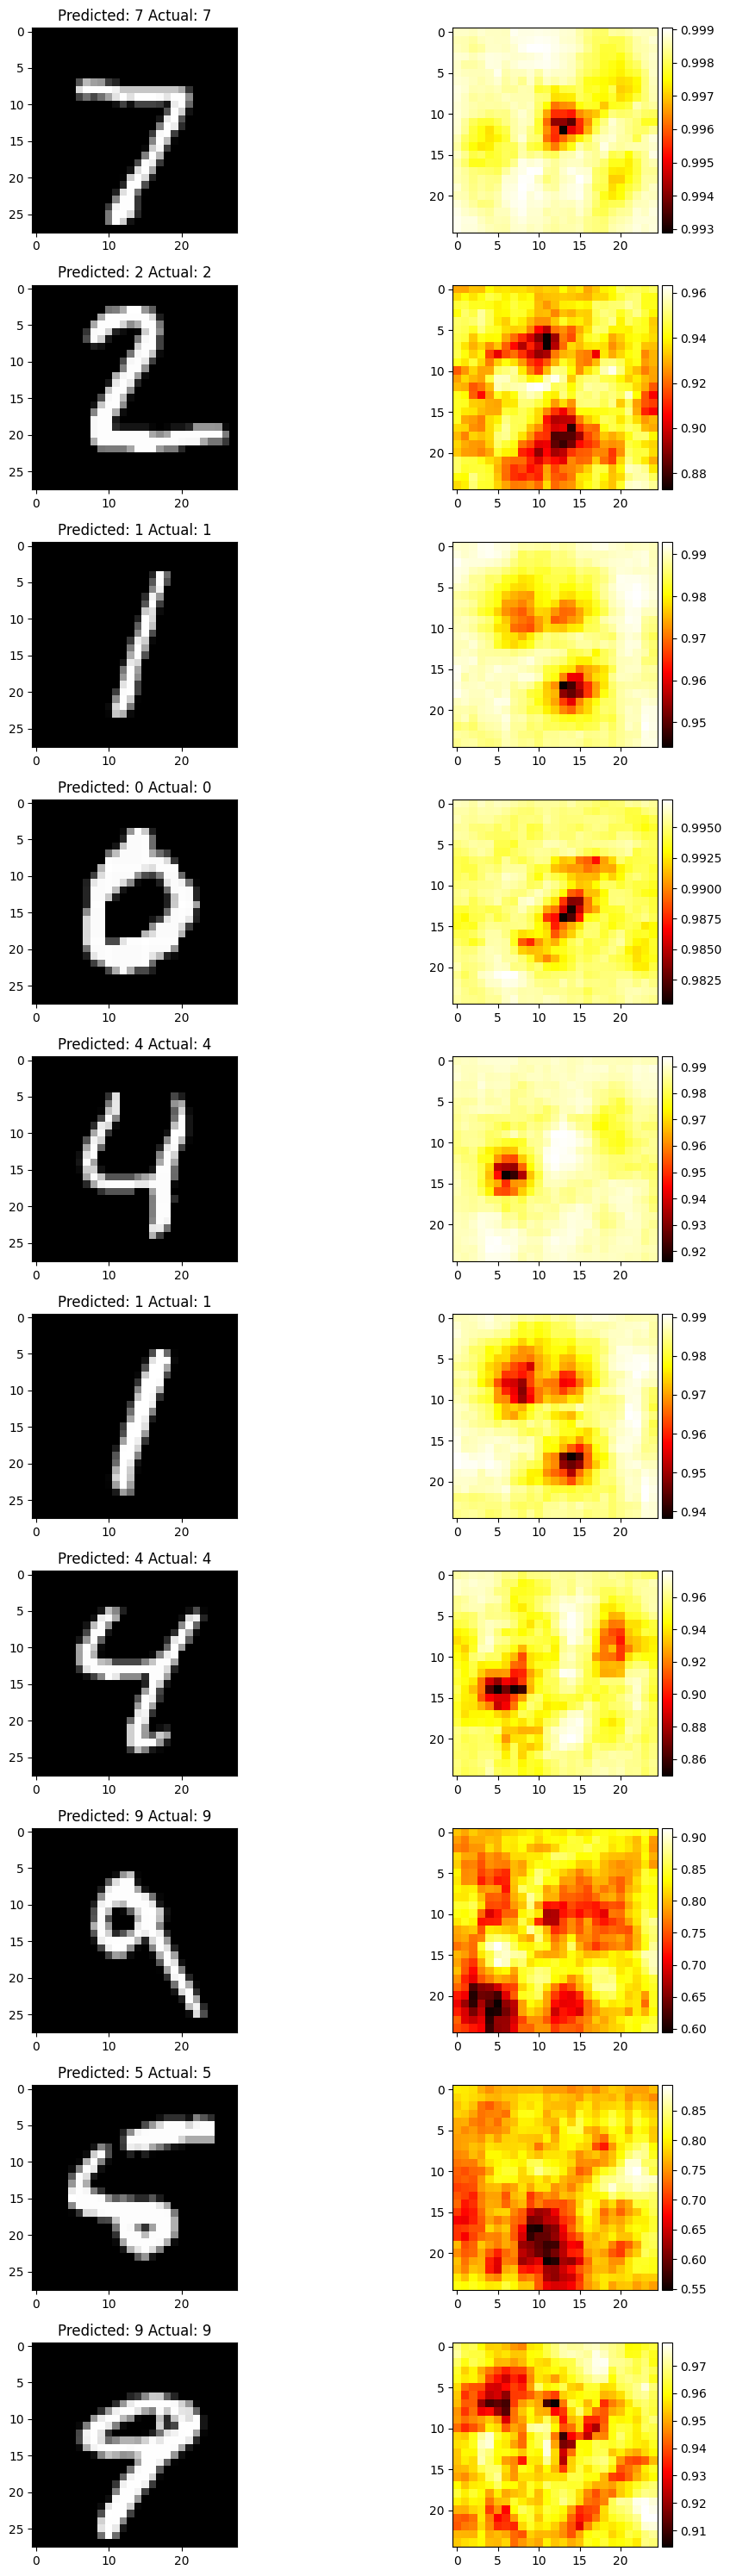

In [48]:
visualize_occlusion(sgd_bn_model, test_loader, num_images = 10, occ_size = 3)

## Occlusion Filter Size = 5

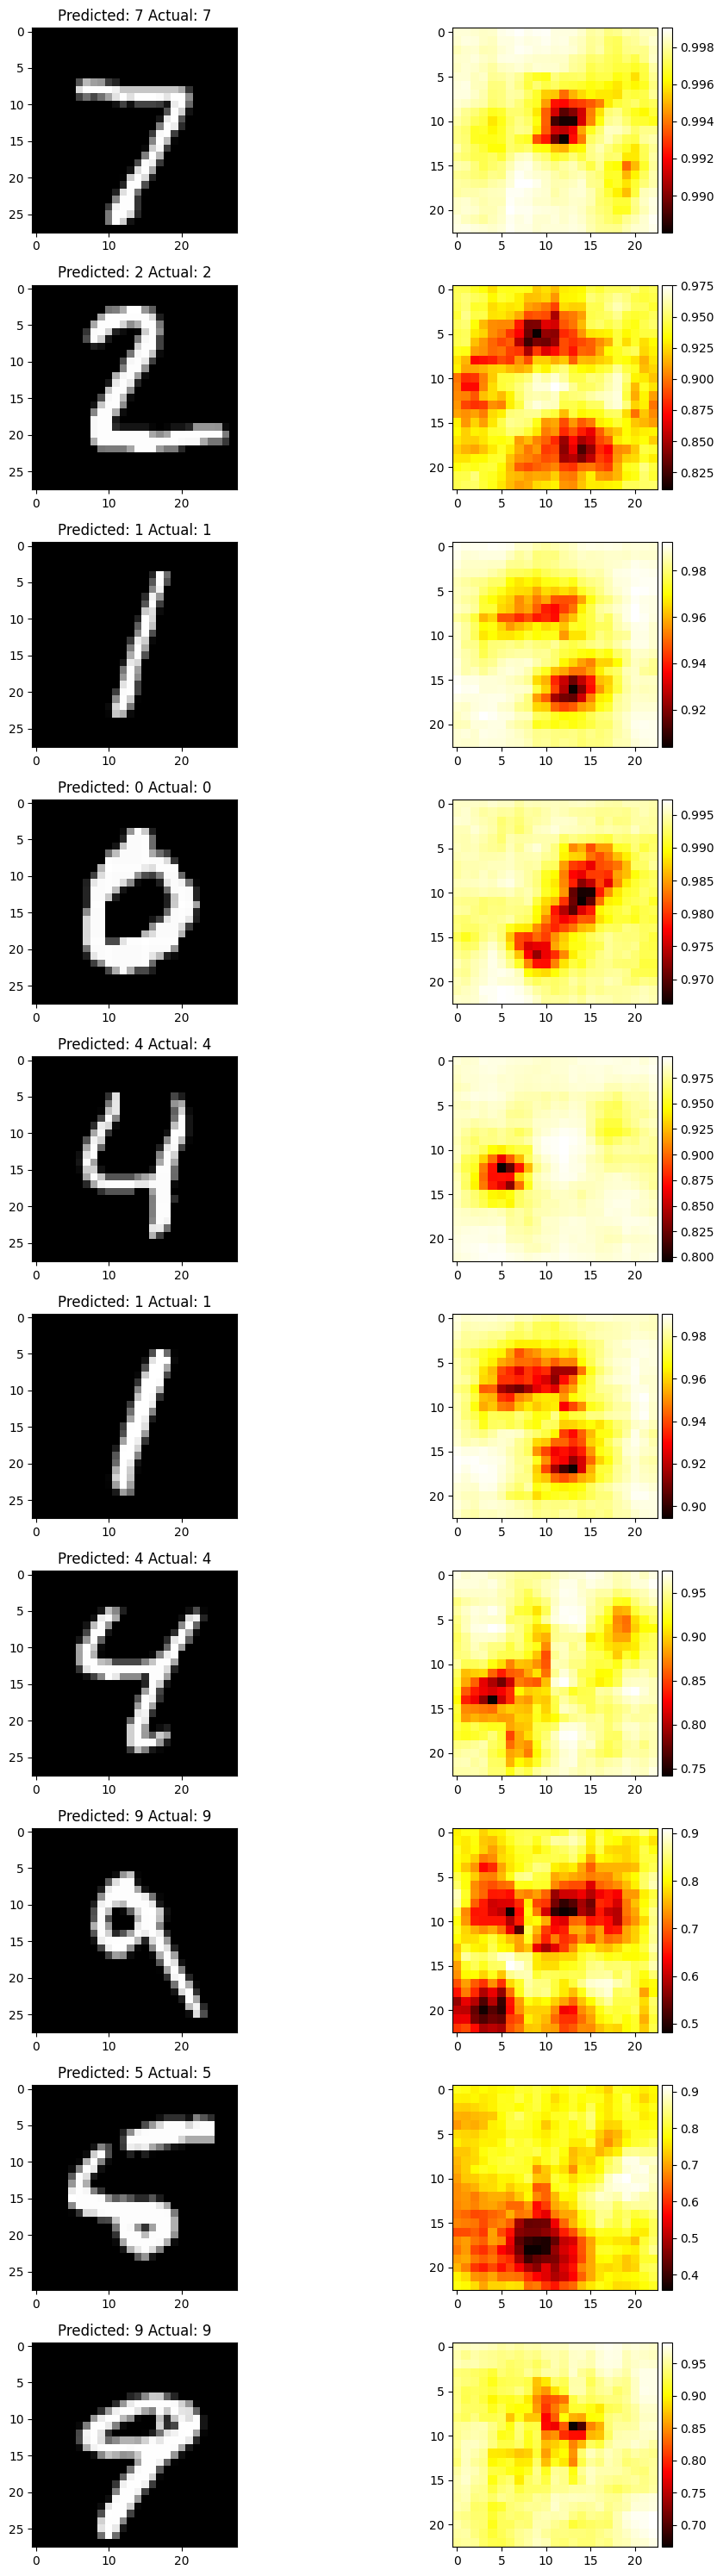

In [49]:
visualize_occlusion(sgd_bn_model, test_loader, num_images = 10, occ_size = 5)

## Occlusion Filter Size = 7

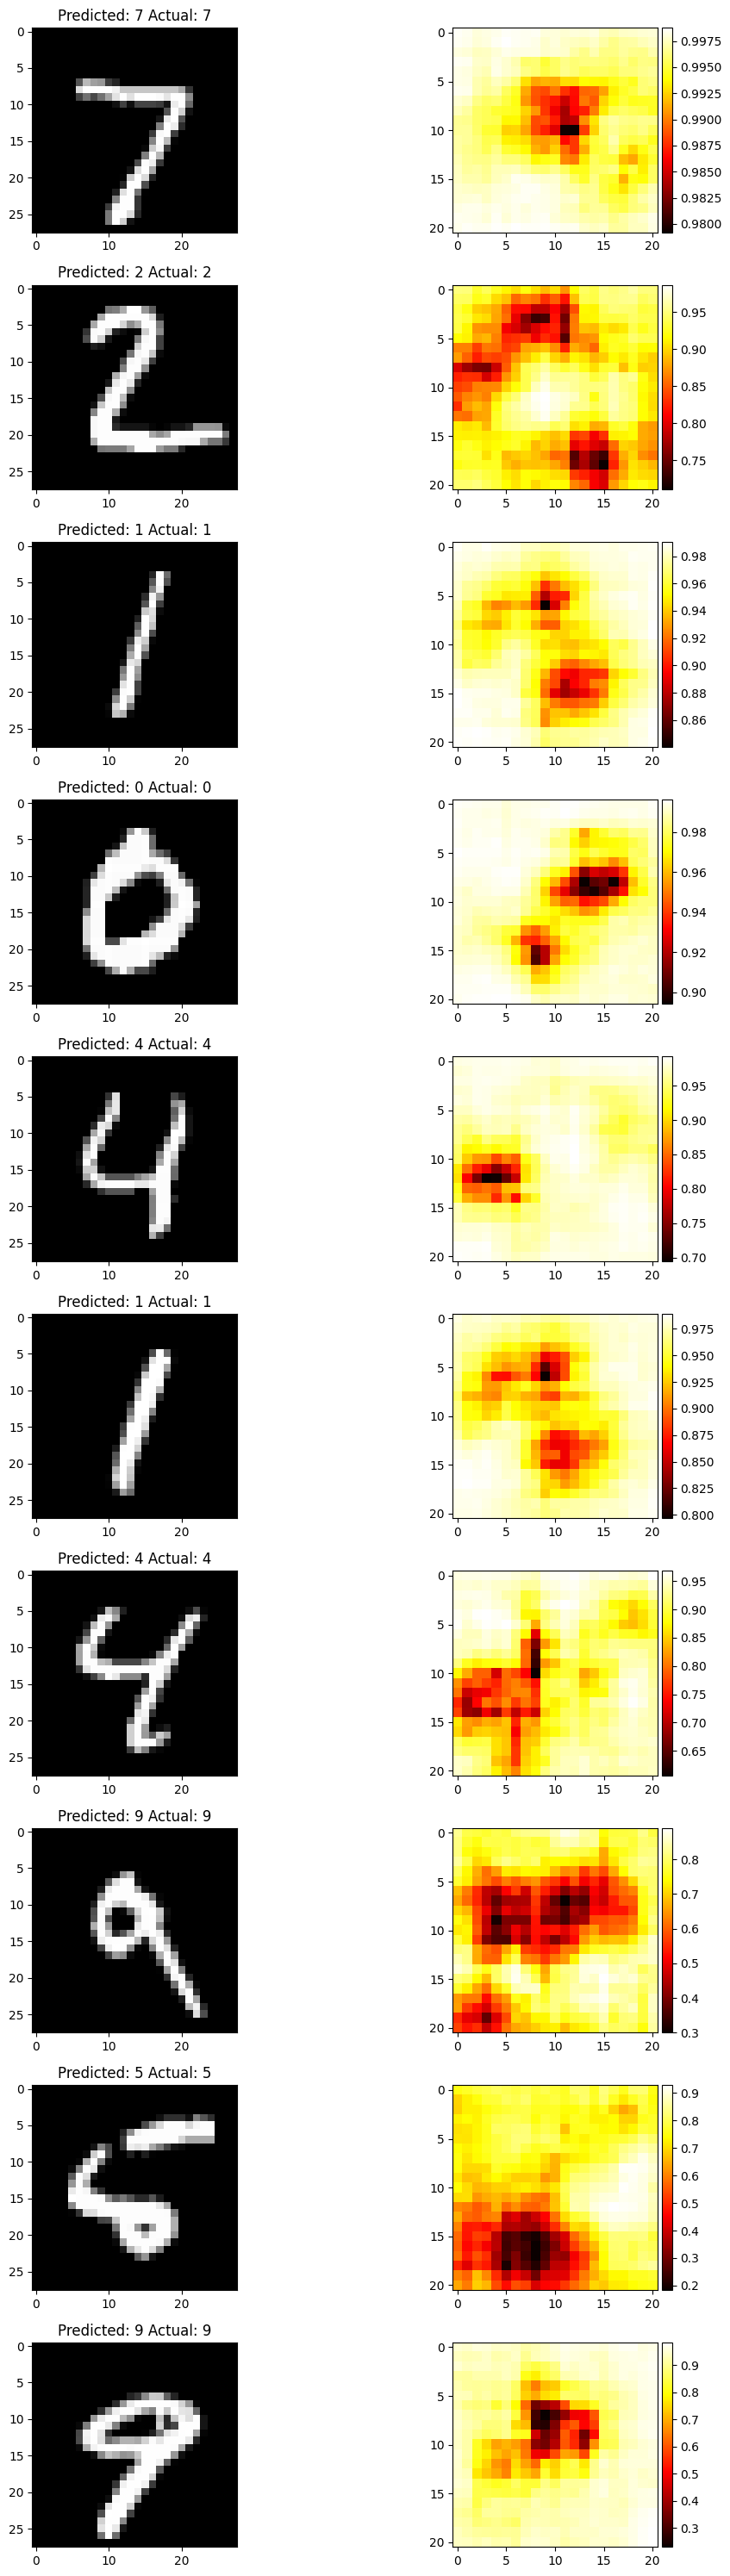

In [50]:
visualize_occlusion(sgd_bn_model, test_loader, num_images = 10, occ_size = 7)

## Occlusion Filter Size = 14

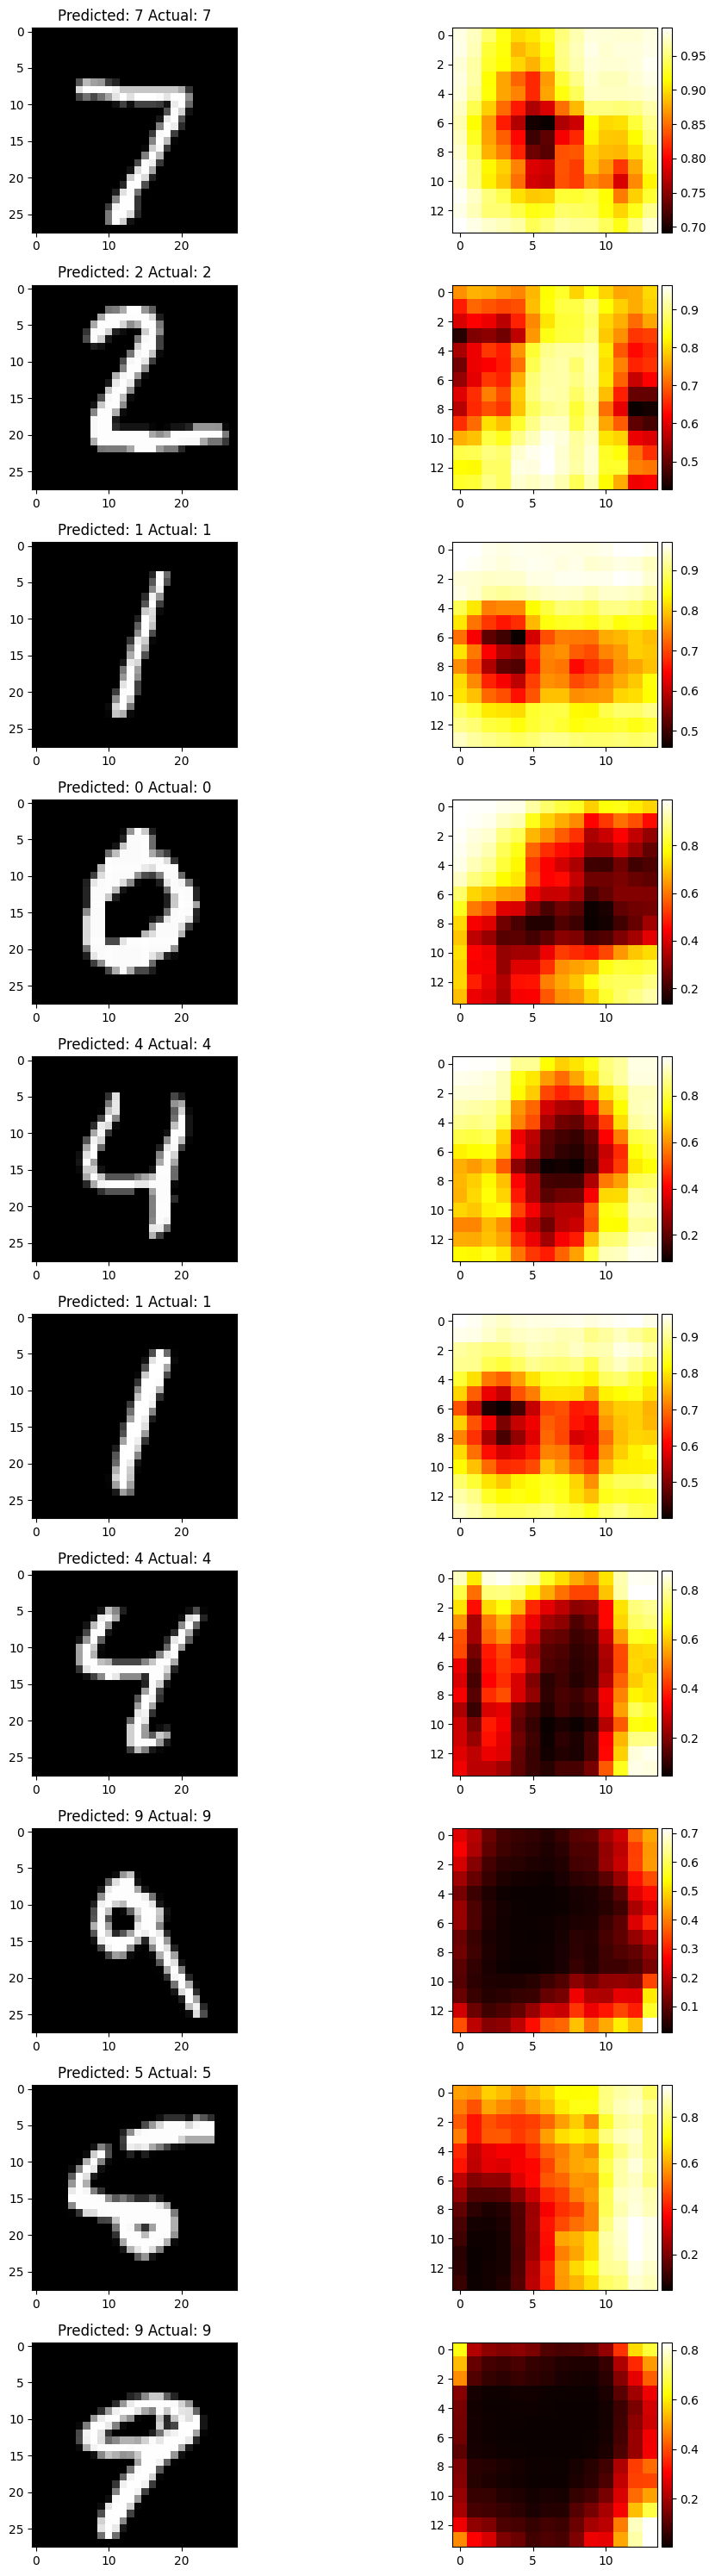

In [51]:
visualize_occlusion(sgd_bn_model, test_loader, num_images = 10, occ_size = 14)

## Observations

The heatmaps illustrate that when the patch obscures the central part or other parts of the number, the likelihood of correctly identifying the true class diminishes. Conversely, when the patch is positioned in the background, the probability of recognizing the true class stays consistent. This suggests that the network heavily relies on the shape of the number for accurate prediction, indicating that its learning process is substantive.

We also see that the model's confidence across regions drops as we increase the size of filter; however the behaviour is different. For small filter sizes, the regions of uncertainity are numerous are sparsely spread out, however, for large filters the region(s) of uncertainity is (are) usually quite dense. This is because in such cases, the occlusion is able to cover the entire/good chunk of the number/its shape/its outline/its pattern.

Across multiple runs, it was observed that:
* The performance on images with label = 1 isn't affected drastically unless its middle section is occluded.
* The circular loops in the shapes of digits 6 and 9 are quite important for recognising them.
* Models might consue between 4 and 9 for samples in which 4 is written like H without the bottom left section and 9 is written as H with the  bottom left section covering its top or as an mirror-image of P.

# Non-targeted Adversarial Attack

In [66]:
def generate_adversarial_example_with_costs(model, target_class, stepsize=0.05, max_iterations=10000, epsilon=0.3, use_epsilon=True):
    model.eval()

    X = torch.normal(128, 1, (1, 1, 28, 28)).to(device)
    X.requires_grad = True

    costs = []

    for iteration in range(max_iterations):
        logits = model(X)

        cost = logits[0, target_class]
        costs.append(cost.item())

        model.zero_grad()

        cost.backward()

        perturbation = stepsize * X.grad.data
        if use_epsilon:
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        X.data = X.data + perturbation

        X.data = torch.clamp(X.data, 0, 255)
        X.grad.data.zero_()

    return X.detach(), costs

In [67]:
def plot_costs_for_target_class(generated_examples, target_class):
    costs = generated_examples['cost'][target_class]

    plt.figure(figsize=(8, 6))
    plt.plot(costs)
    plt.xlabel('Iterations')
    plt.ylabel('Cost Value')
    plt.title(f"Cost Function for Target Class {target_class} over Iterations")
    plt.grid(True)
    plt.show()

In [68]:
def display_adversarial_images(generated_examples):
    plt.figure(figsize=(10, 5))
    for i, img in generated_examples['gen_egs'].items():
        plt.subplot(2, 5, i+1)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        plt.title(f"Target: {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [69]:
def check_network_predictions(model, generated_examples):
    for i, img in generated_examples['gen_egs'].items():
        logits = model(img)
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()

        print(f"Target Class: {i}, Predicted Class: {pred_class}, Confidence: {confidence:.4f}")

In [70]:
generated_examples = {'gen_egs': {}, 'cost': {}}
for i in range(10):
    gen_eg, cost = generate_adversarial_example_with_costs(adam_bn_model, i)
    generated_examples['gen_egs'][i] = gen_eg
    generated_examples['cost'][i] = cost

In [71]:
check_network_predictions(adam_bn_model, generated_examples)

Target Class: 0, Predicted Class: 0, Confidence: 1.0000
Target Class: 1, Predicted Class: 1, Confidence: 1.0000
Target Class: 2, Predicted Class: 2, Confidence: 1.0000
Target Class: 3, Predicted Class: 3, Confidence: 1.0000
Target Class: 4, Predicted Class: 4, Confidence: 1.0000
Target Class: 5, Predicted Class: 5, Confidence: 1.0000
Target Class: 6, Predicted Class: 6, Confidence: 1.0000
Target Class: 7, Predicted Class: 7, Confidence: 1.0000
Target Class: 8, Predicted Class: 8, Confidence: 1.0000
Target Class: 9, Predicted Class: 9, Confidence: 1.0000


The model predicts the target class correctly with very high confidence in each case, meaning that the adversarial attack has been successful.

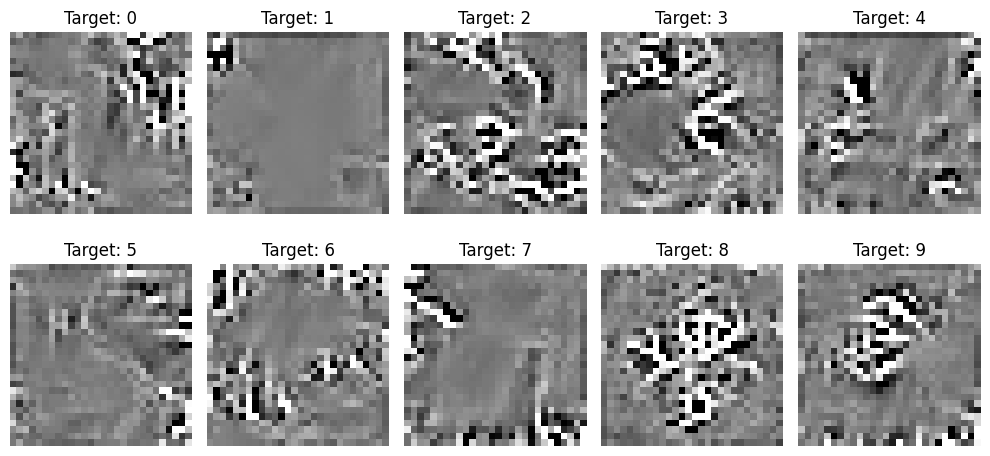

In [72]:
display_adversarial_images(generated_examples)

The adversarial images do not look like numbers at all (except for 2, 3 and 8) but are able to fool the neural network. This is because the adversarial perturbations exploit the model's vulnerabilities, which do not necessarily correspond to human perception. The reasons include:


*   The model learns high-dimensional decision boundaries, which can be exploited by tiny, imperceptible perturbations.
*   The attack focuses on maximizing a specific output class, not necessarily making the image look like that class to humans.
* Neural networks consider every pixel in the image, whereas humans focus on more recognizable patterns and features.
* This might also be because of the absence of an image prior in the objective function



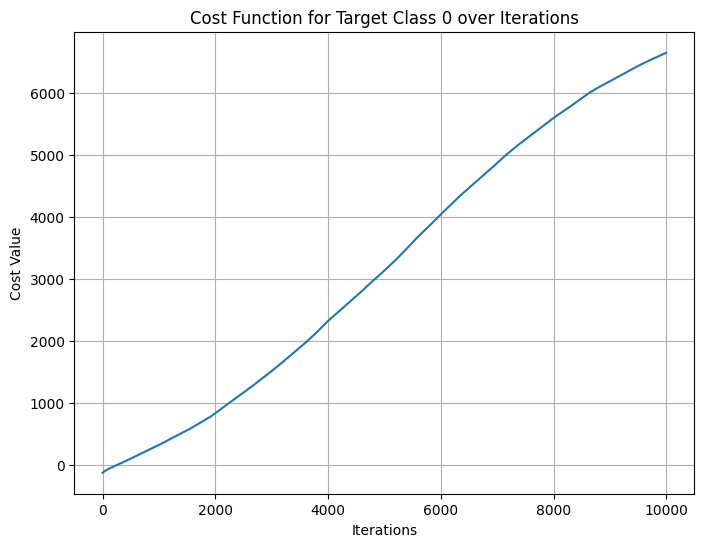

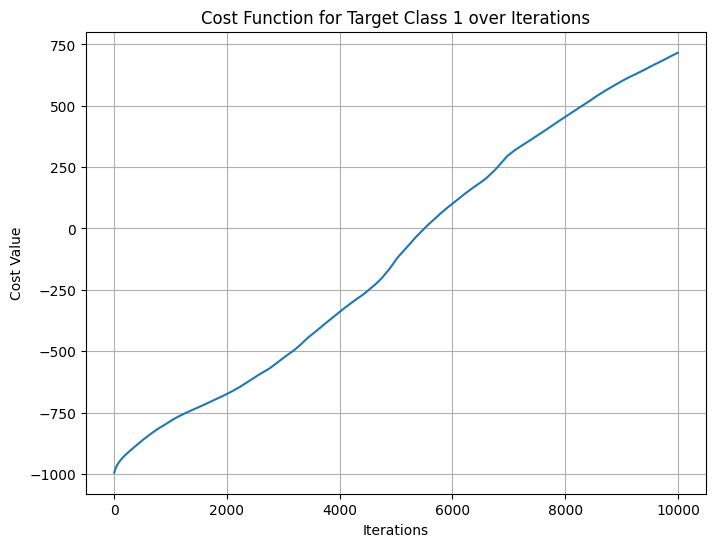

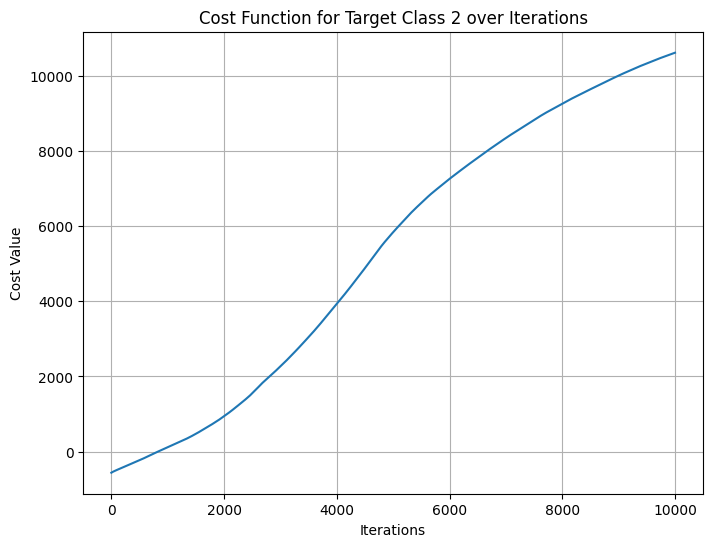

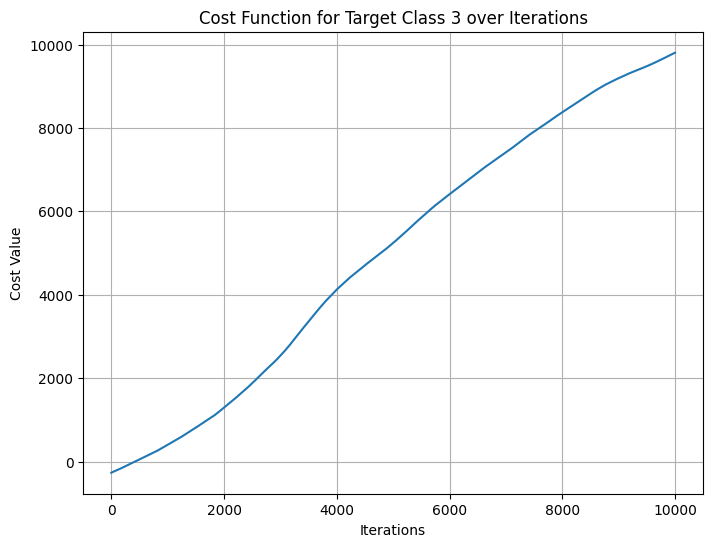

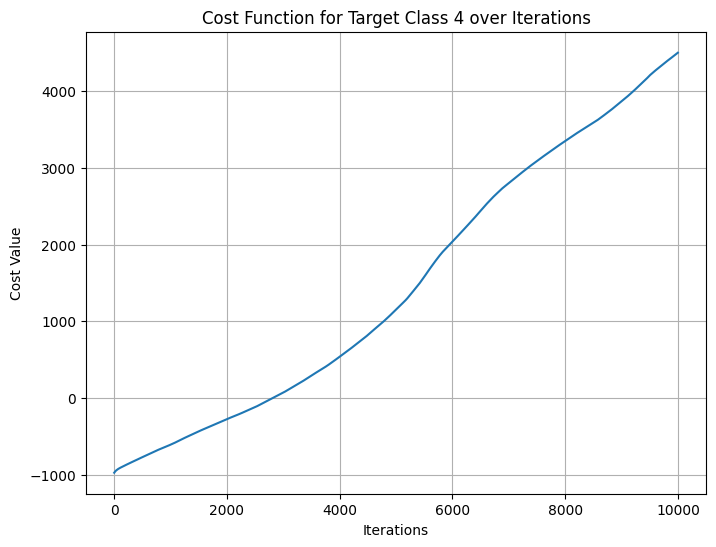

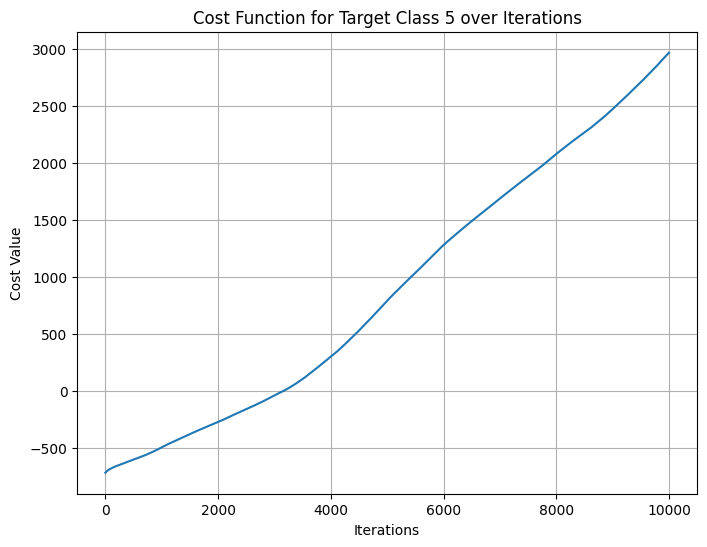

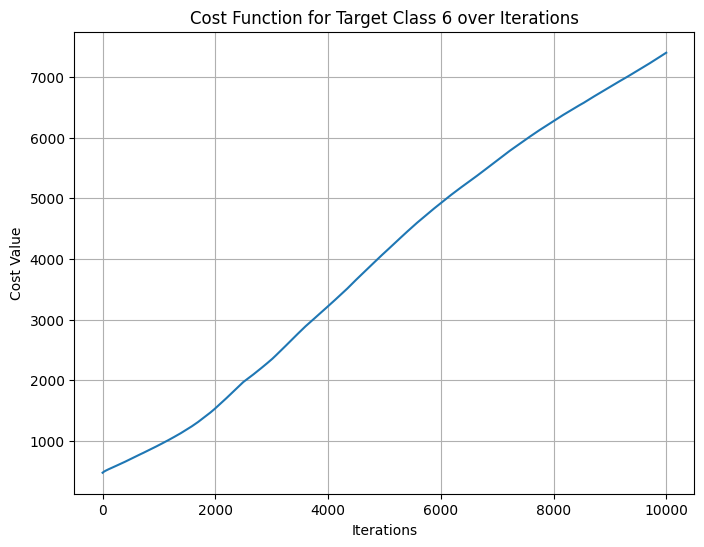

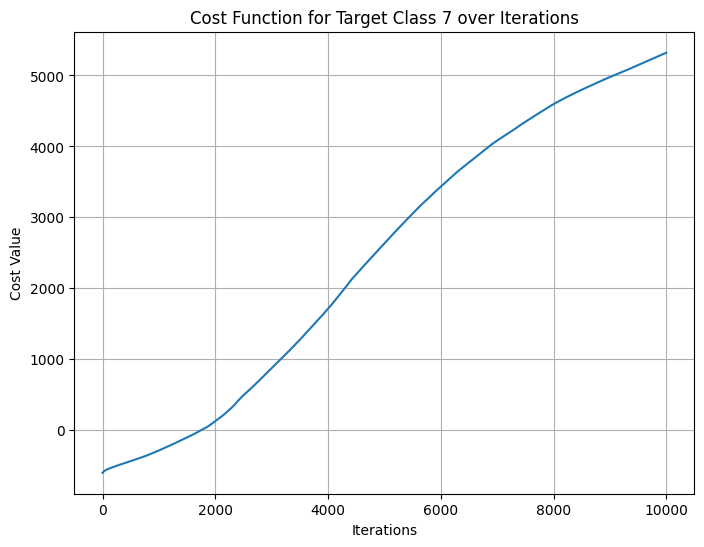

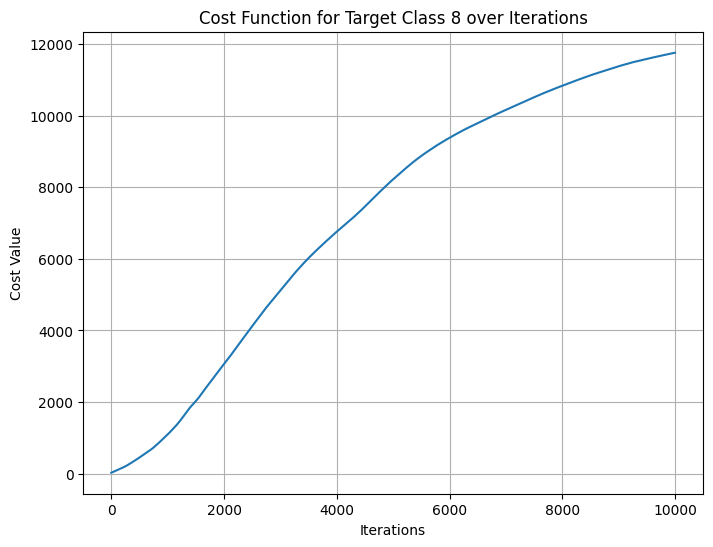

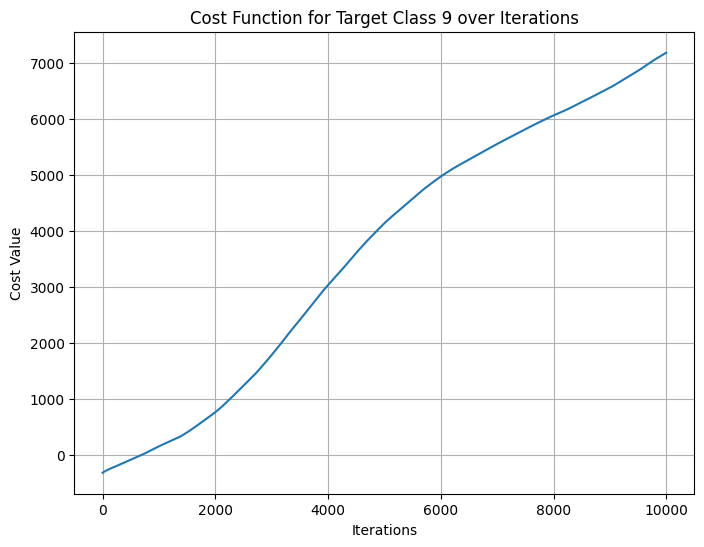

In [73]:
for i in range(10):
    plot_costs_for_target_class(generated_examples, i)

Since we are performing gradient ascent on the target class's logit, the cost function should generally increase over iterations until it possibly sort of plateaus, as seen in some cases.

# Targeted Adversarial Attack

In [74]:
def generate_target_adversarial_example(model, target_class, target_image, stepsize=0.05, max_iterations=5000, epsilon=0.3, use_epsilon=True, beta=0.001):
    model.eval()

    X = torch.normal(128, 1, (1, 1, 28, 28)).to(device)
    X.requires_grad = True

    mse_loss = nn.MSELoss()

    for iteration in range(max_iterations):
        logits = model(X)

        cost = logits[0, target_class] - beta * mse_loss(X, target_image)

        model.zero_grad()

        cost.backward()

        perturbation = stepsize * X.grad.data
        if use_epsilon:
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        X.data = X.data + perturbation

        X.data = torch.clamp(X.data, 0, 255)
        X.grad.data.zero_()

    return X.detach()

In [75]:
def classwise_adversarial_example(model, dataset, beta=0.001):
    target_images = {}
    for _, (images, labels) in enumerate(dataset):
        for img, label in zip(images, labels):
            if label.item() not in target_images:
                target_images[label.item()] = img.to(device)
            if len(target_images) == 10:
                break
        if len(target_images) == 10:
            break

    adversarial_images = {}
    for true_digit, target_img in target_images.items():
        for target_digit in range(10):
            if true_digit != target_digit:
                adv_img = generate_target_adversarial_example(model, target_digit, target_img.unsqueeze(0), beta=beta)
                adversarial_images[(true_digit, target_digit)] = adv_img

    # Displaying the generated images
    plt.figure(figsize=(20, 20))
    for i, ((true_digit, target_digit), img) in enumerate(adversarial_images.items()):
        plt.subplot(10, 9, i+1)
        plt.imshow(img[0,0].cpu().numpy(), cmap='gray')
        plt.title(f"Looks: {true_digit}, Predicted: {target_digit}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

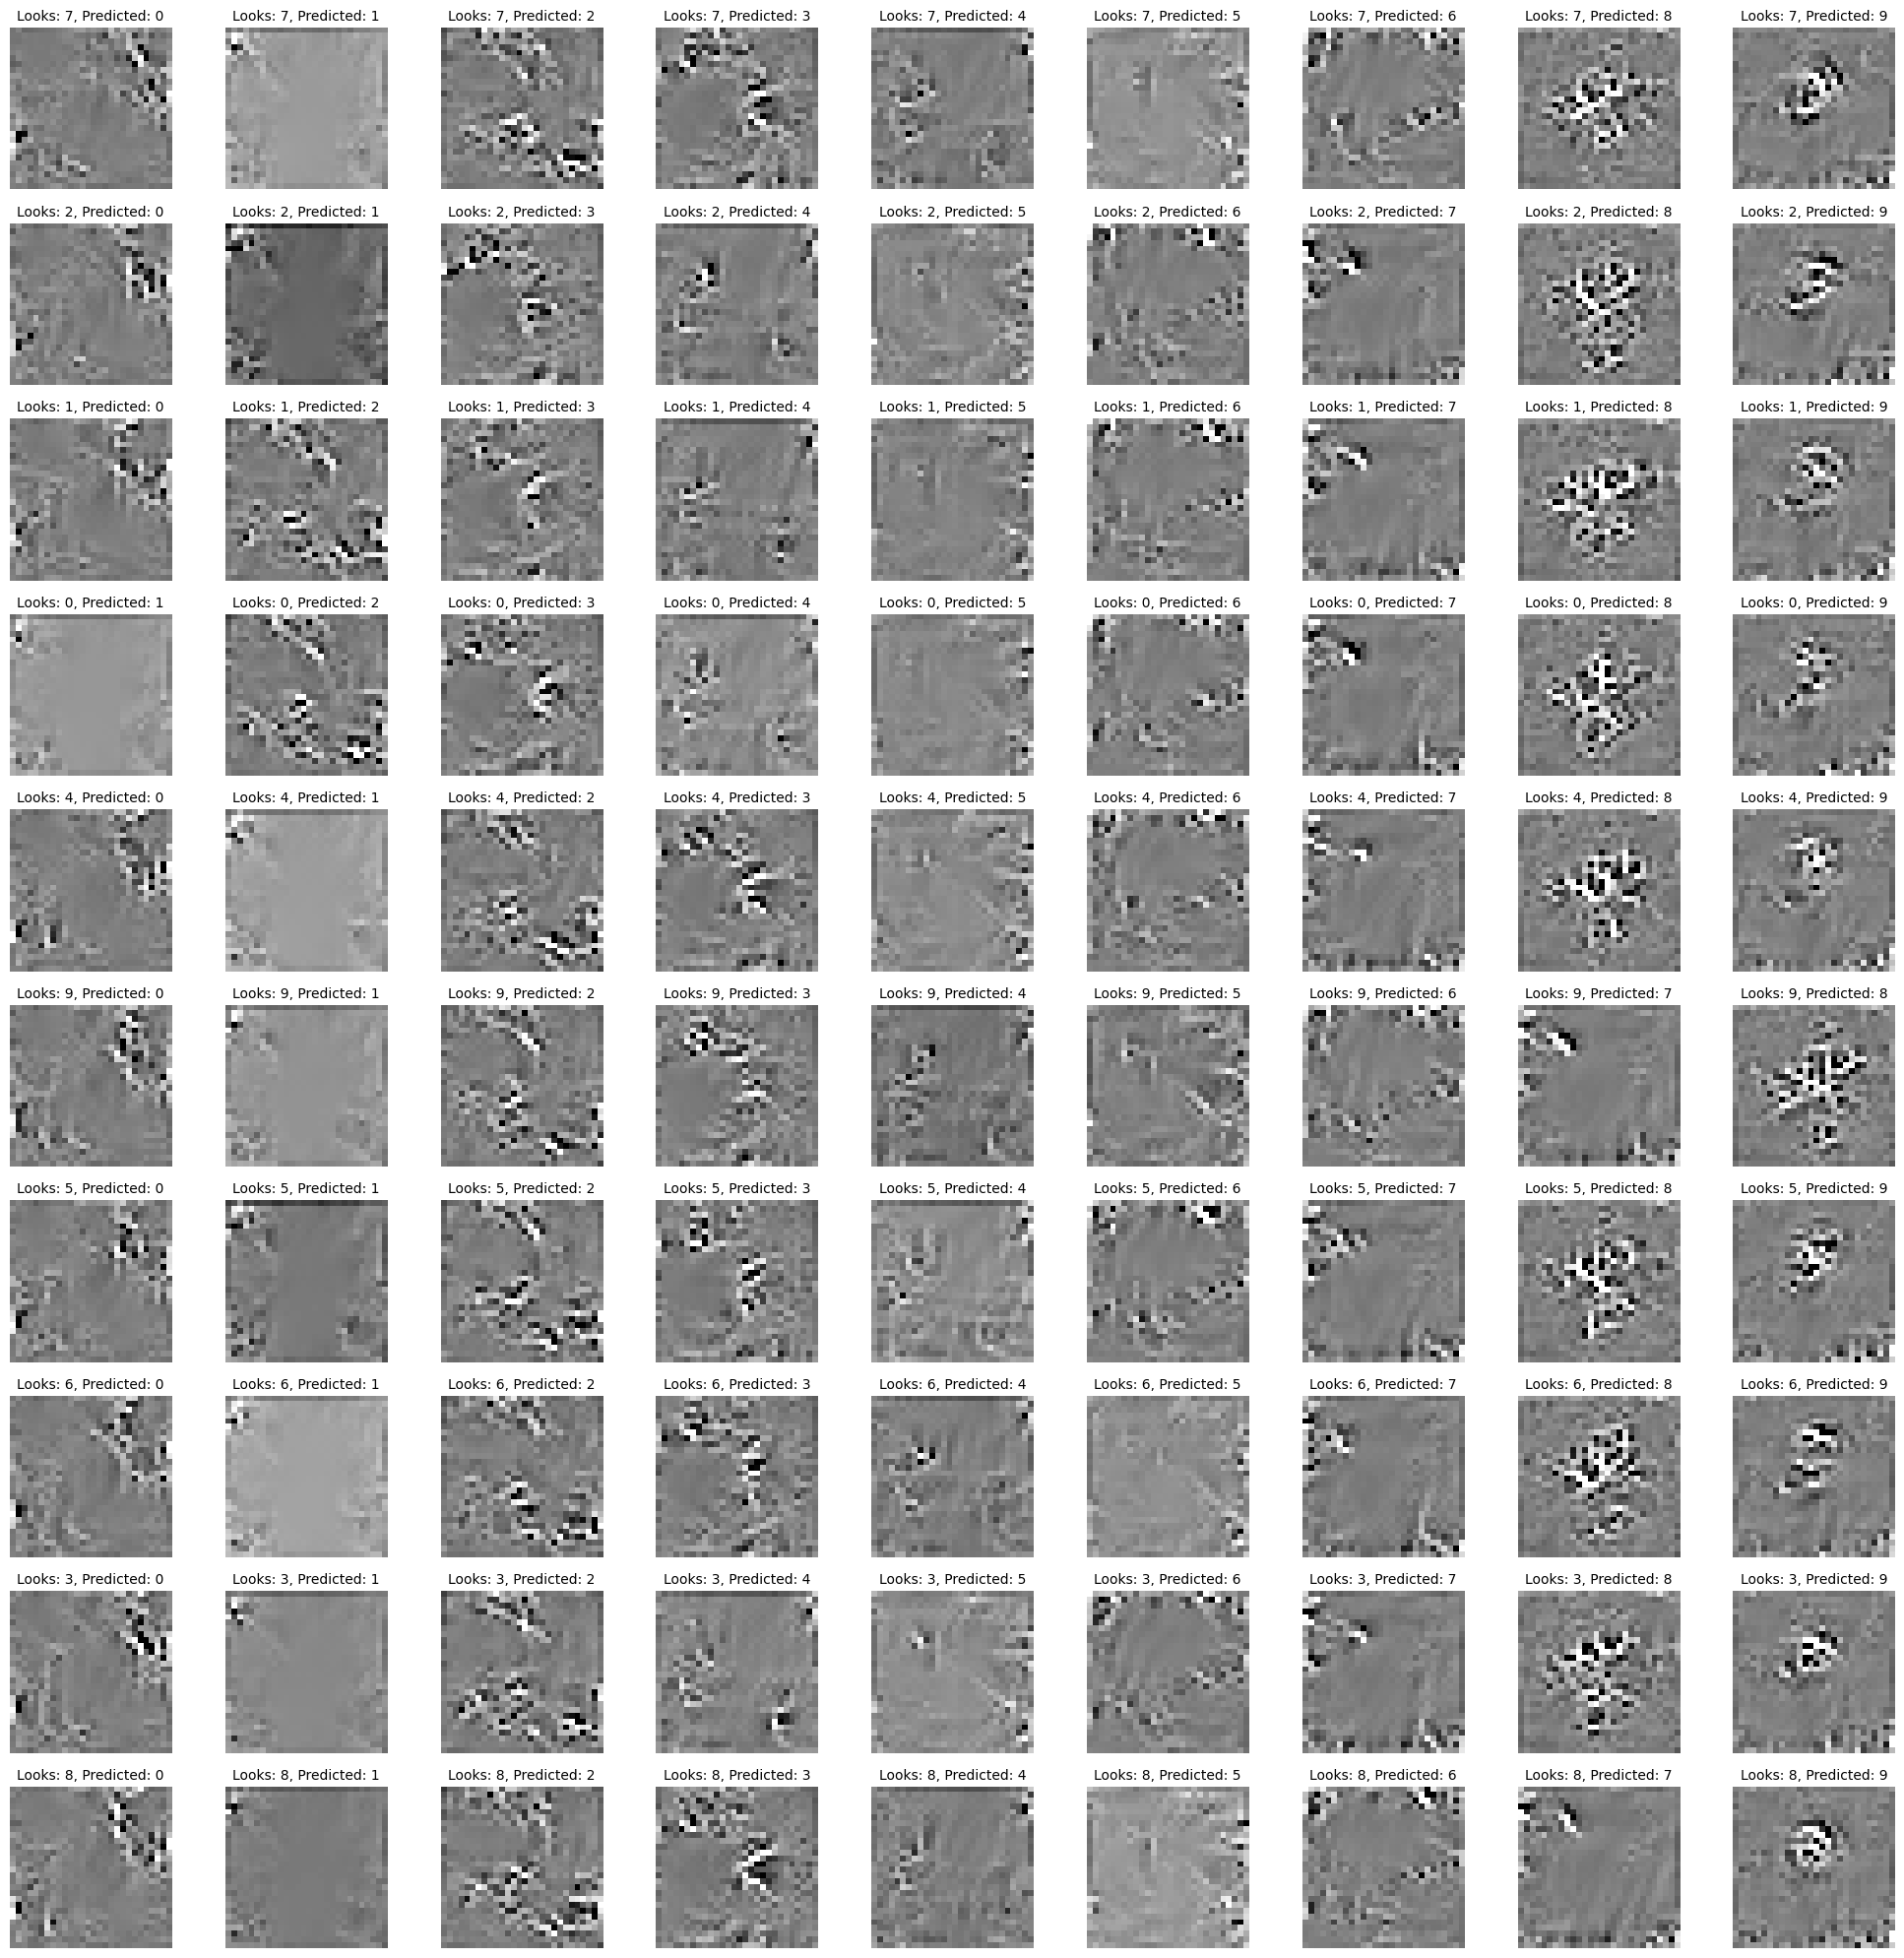

In [76]:
classwise_adversarial_example(adam_bn_model, test_loader)


The appearance of the generated images resembling numbers in some cases cane be attributed to the inclusion of an image prior within the objective function.